In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
from conformal_region_designer.case_studies.car_experiments import CarEnvironment, generate_calibration_dataset, generate_train_dataset, TrajectoryPredictor
from conformal_region_designer.utils import set_square_aspect_ratio, shuffle_split_testing, conformalized_quantile

In [3]:
import random
random.seed(42)
np.random.seed(42)
train_X, train_Y = generate_train_dataset(100)
env_X, env_Y = generate_calibration_dataset(10_000)

In [4]:
predictor = TrajectoryPredictor(0.1)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Text(0.5, 0.98, 'Training Trajectories')

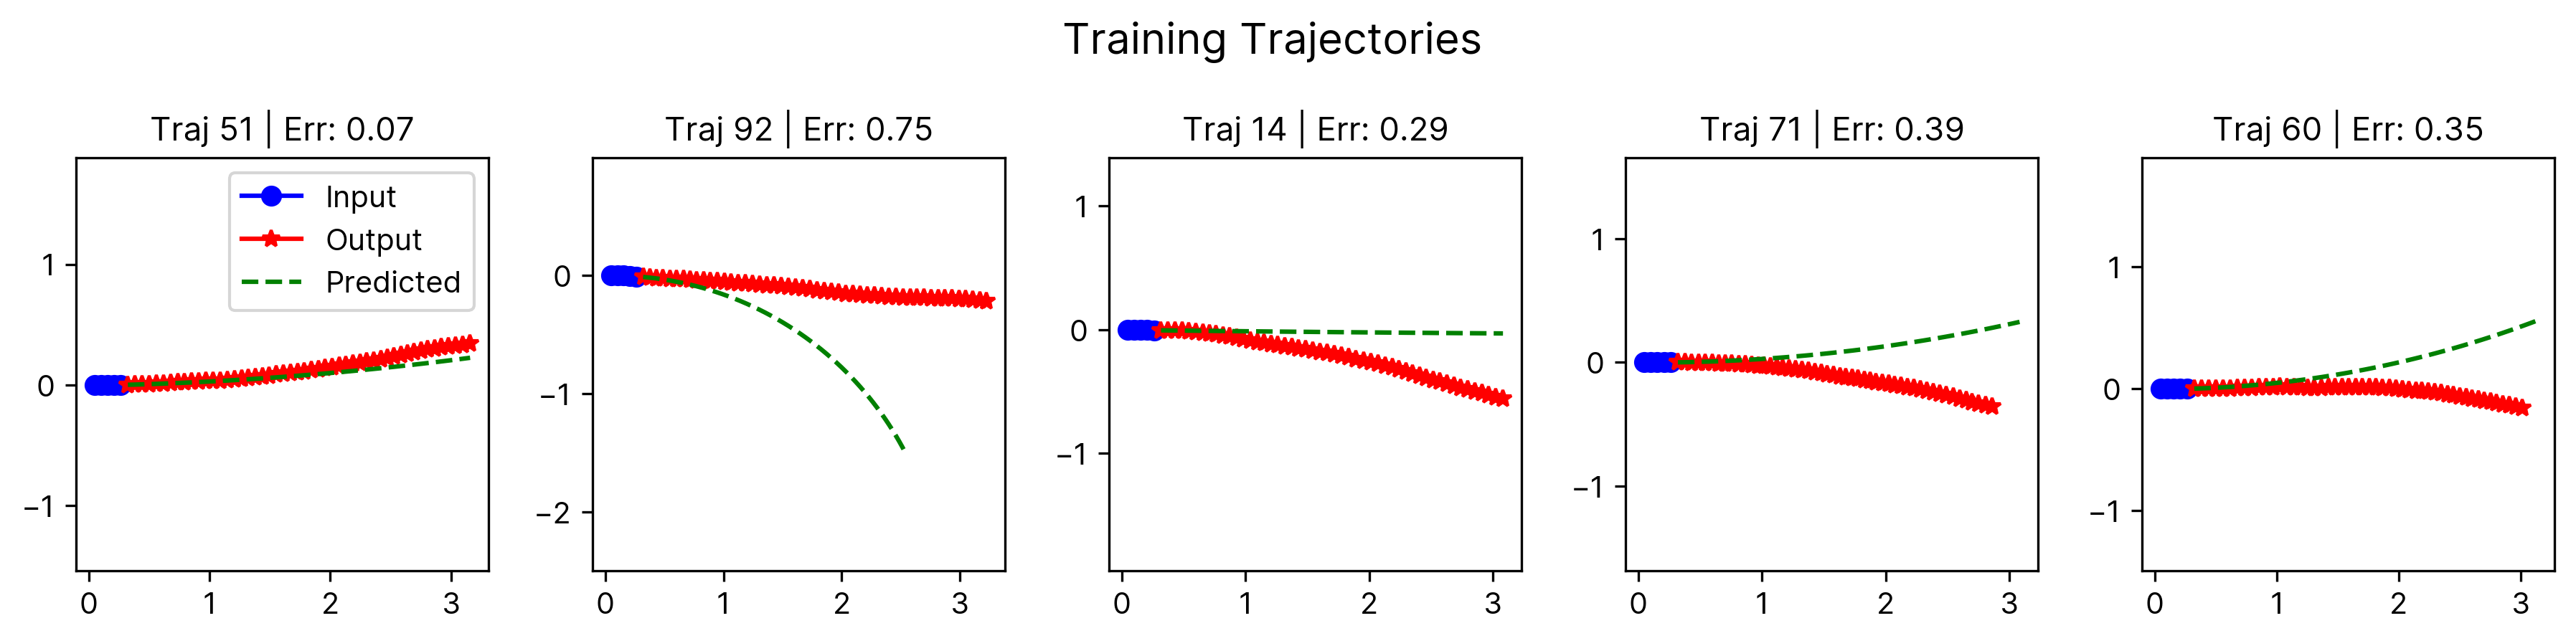

In [5]:
INDEX = np.random.choice(train_X.shape[0], 5)
fig, axs = plt.subplots(1, 5, figsize=(12, 3), dpi=300, constrained_layout=True)
for i, ax in enumerate(axs.flat):
    ax.plot(train_X[INDEX[i], :, 0], train_X[INDEX[i], :, 1], 'bo-', label='Input')
    ax.plot(train_Y[INDEX[i], :, 0], train_Y[INDEX[i], :, 1], 'r*-', label='Output')
    prediction = predictor.predict_trajectory(train_X[INDEX[i]])
    error = np.linalg.norm(prediction - train_Y[INDEX[i]], axis=1)
    ax.plot(prediction[:, 0], prediction[:, 1], 'g--', label='Predicted')
    ax.set_title(f'Traj {INDEX[i]} | Err: {error.mean():.2f}')
    set_square_aspect_ratio(ax)
axs.flat[0].legend()
plt.suptitle('Training Trajectories')

Text(0.5, 0.98, 'Calibration Distribution')

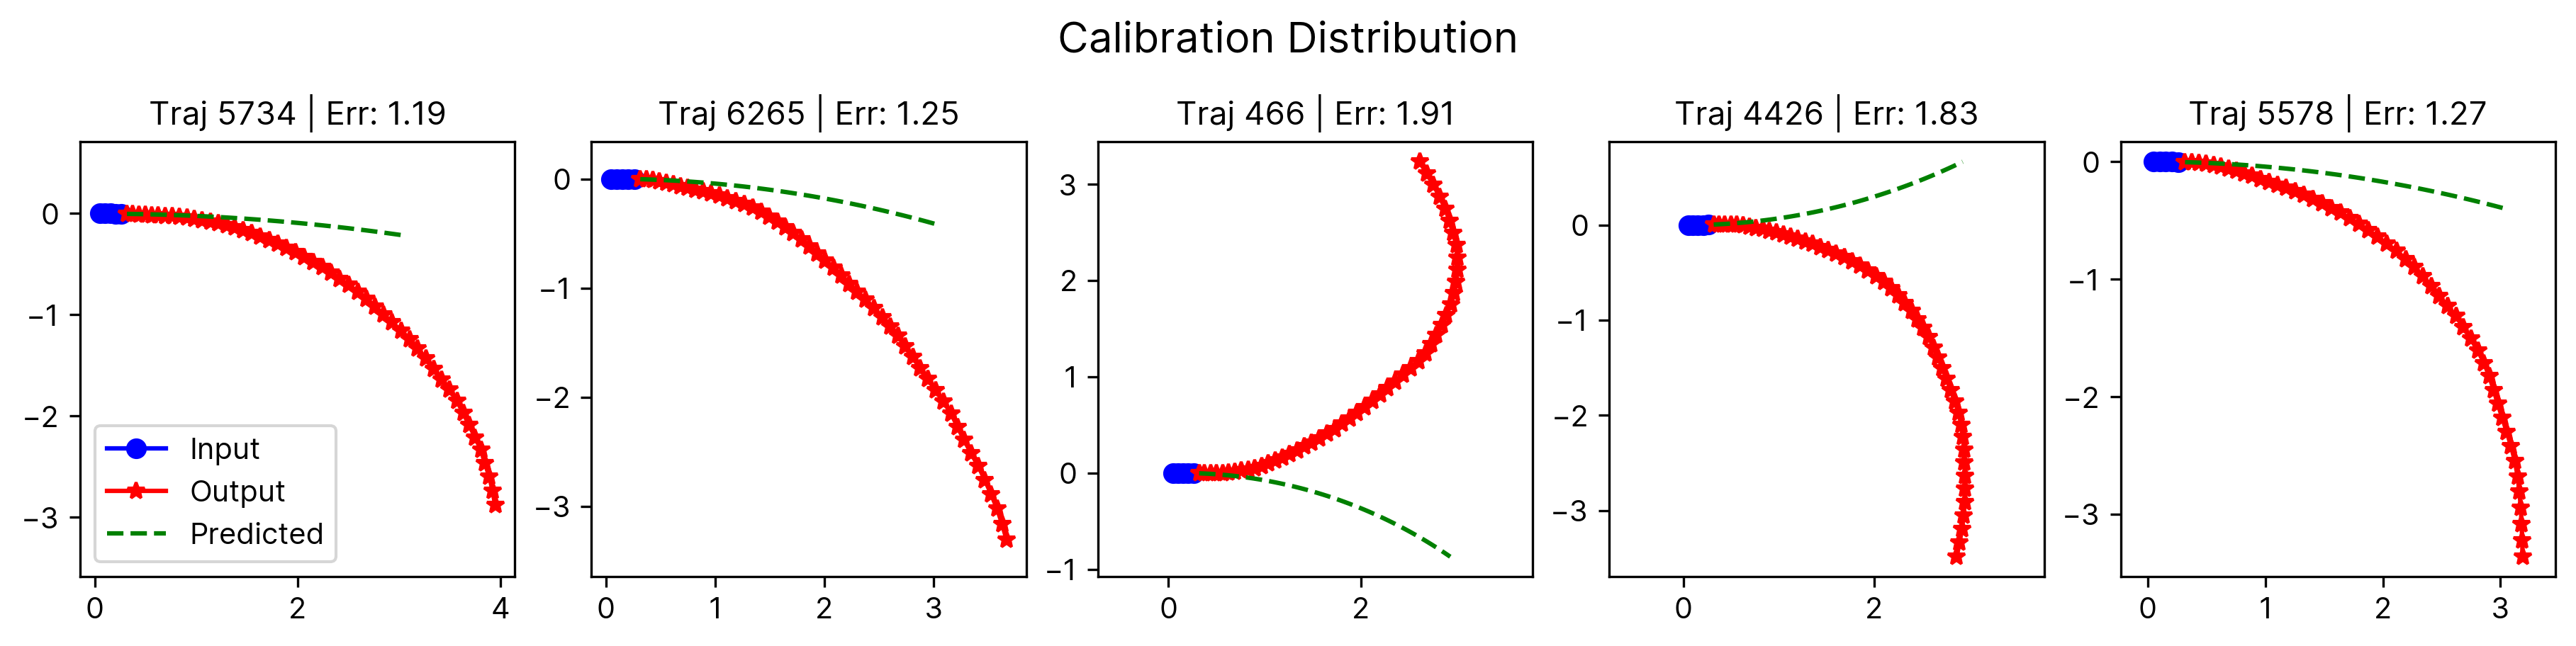

In [6]:
INDEX = np.random.choice(env_X.shape[0], 5)
fig, axs = plt.subplots(1, 5, figsize=(12, 3), dpi=300, constrained_layout=True)
for i, ax in enumerate(axs.flat):
    ax.plot(env_X[INDEX[i], :, 0], env_X[INDEX[i], :, 1], 'bo-', label='Input')
    ax.plot(env_Y[INDEX[i], :, 0], env_Y[INDEX[i], :, 1], 'r*-', label='Output')
    prediction = predictor.predict_trajectory(env_X[INDEX[i]])
    error = np.linalg.norm(prediction - env_Y[INDEX[i]], axis=1)
    ax.plot(prediction[:, 0], prediction[:, 1], 'g--', label='Predicted')
    ax.set_title(f'Traj {INDEX[i]} | Err: {error.mean():.2f}')
    set_square_aspect_ratio(ax)
axs.flat[0].legend()
fig.suptitle('Calibration Distribution')

In [7]:
TIMESTEPS = [10, 20, 30, 40, 49]
env_Y_hat = predictor.predict_batched_trajectories(env_X)
Z_env = env_Y[:,TIMESTEPS,:2] - env_Y_hat[:,TIMESTEPS,:2]
np.random.shuffle(Z_env)

In [8]:
Z_env.shape

(10000, 5, 2)

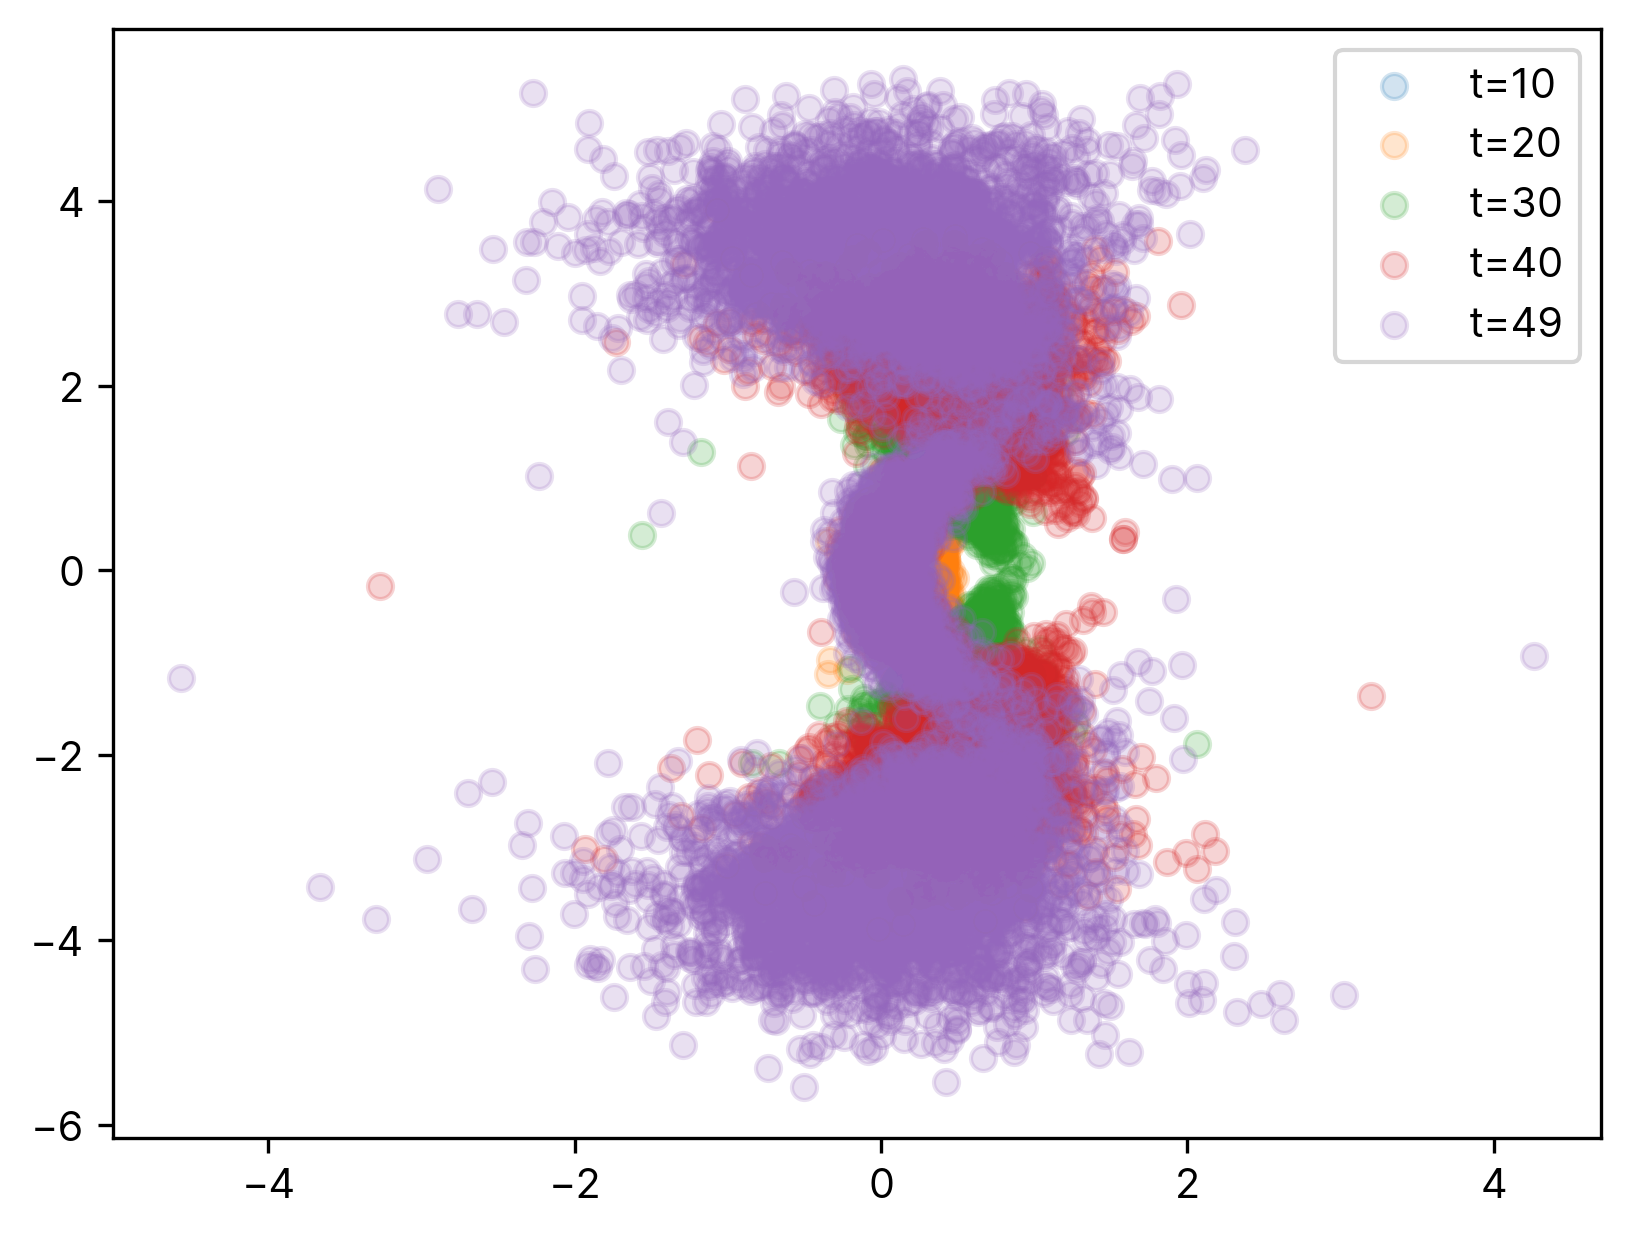

In [9]:
for i,ts in enumerate(TIMESTEPS):
    plt.scatter(Z_env[:,i,0], Z_env[:,i,1], alpha=0.2, label=f"t={ts}")
plt.legend()

# Use Parametrized Conformal Regions for Prediction

In [10]:
from conformal_region_designer.conformity_optimizer import ConformalRegionTimeSeries
DELTA = 0.90
BW_FACTOR = 0.3

In [11]:
Z_cal_one = Z_env[:Z_env.shape[0]//3]
Z_cal_two = Z_env[Z_env.shape[0]//3:2*(Z_env.shape[0]//3)]
Z_test = Z_env[2*(Z_env.shape[0]//3):]
Z_eval = Z_env[(Z_env.shape[0]//3):]
print(Z_cal_one.shape, Z_cal_two.shape, Z_test.shape)

(3333, 5, 2) (3333, 5, 2) (3334, 5, 2)


In [12]:
### Calculate benchmark CP regions.
## First, we calculate the non-conformity scores for each timestep.
benchmark_raw_ncs_cal_one = np.zeros((Z_cal_one.shape[0], len(TIMESTEPS)))
benchmark_raw_ncs_cal_two = np.zeros((Z_cal_two.shape[0], len(TIMESTEPS)))
benchmark_raw_ncs_test = np.zeros((Z_test.shape[0], len(TIMESTEPS)))
for i,ts in enumerate(TIMESTEPS):
    benchmark_raw_ncs_cal_one[:,i] = np.linalg.norm(Z_cal_one[:,i,:], axis=1)
    benchmark_raw_ncs_cal_two[:,i] = np.linalg.norm(Z_cal_two[:,i,:], axis=1)
    benchmark_raw_ncs_test[:,i] = np.linalg.norm(Z_test[:,i,:], axis=1)

## Next, we create our non-conformity quantiles.
benchmark_ind_ncb_cal_one = np.quantile(benchmark_raw_ncs_cal_one, DELTA, axis=0)
benchmark_ind_ncb_cal_two = np.quantile(benchmark_raw_ncs_cal_two, DELTA, axis=0)
benchmark_ind_ncb_test = np.quantile(benchmark_raw_ncs_test, DELTA, axis=0)

## We create two normalization schemes
# 1. Time-based normalization
benchmark_norm_time_based = np.array([1/i for i in range(1, len(TIMESTEPS)+1)])
# 2. Ratio-based normalization
upper_quantile = np.quantile(benchmark_raw_ncs_cal_one, DELTA, axis=0)
lower_quantile = np.min(benchmark_raw_ncs_cal_one, axis=0)
benchmark_norm_ratio_based = 1/(upper_quantile - lower_quantile)
benchmark_norm_ratio_based = benchmark_norm_ratio_based / np.sum(benchmark_norm_ratio_based)
# benchmark_norm_ratio_based = benchmark_ind_ncb_cal_one - (np.min(benchmark_ind_ncb_cal_one) - 1)
# benchmark_norm_ratio_based = benchmark_norm_ratio_based / np.sum(benchmark_norm_ratio_based)
# resultant_benchmark_norm = benchmark_ind_ncb_cal_one * benchmark_norm_ratio_based
# benchmark_norm_ratio_based = benchmark_norm_ratio_based * (1/resultant_benchmark_norm)

benchmark_target_quantile = conformalized_quantile(Z_cal_two.shape[0], DELTA)

In [13]:
# from conformal_region_designer.utils import compute_optimized_alphas
# import json
# connection_params = json.load(open('gurobi_key.json', 'r'))
# benchmark_optimized_alphas = compute_optimized_alphas(benchmark_raw_ncs_cal_one, DELTA, connection_params)

In [14]:
# np.save('benchmark_optimized_alphas.npy', benchmark_optimized_alphas)
benchmark_optimized_alphas = np.load('benchmark_optimized_alphas.npy')

In [15]:
benchmark_ind_ncb_cal_one

array([0.15815077, 0.63798662, 1.48834332, 2.72286762, 4.12803194])

In [16]:
print(benchmark_norm_time_based)
benchmark_ind_ncb_cal_one*benchmark_norm_time_based

[1.         0.5        0.33333333 0.25       0.2       ]


array([0.15815077, 0.31899331, 0.49611444, 0.6807169 , 0.82560639])

In [17]:
print(benchmark_norm_ratio_based)
benchmark_ind_ncb_cal_one*benchmark_norm_ratio_based

[0.68924326 0.170893   0.07347162 0.04001106 0.02638106]


array([0.10900436, 0.10902745, 0.109351  , 0.10894481, 0.10890184])

In [18]:
print(benchmark_optimized_alphas)
benchmark_ind_ncb_cal_one*benchmark_optimized_alphas

[0.67518126 0.18489318 0.07412828 0.03956773 0.02622954]


array([0.10678044, 0.11795937, 0.11032834, 0.1077377 , 0.10827639])

In [19]:
benchmark_norm_ratio_based.sum()

0.9999999999999999

In [20]:
## Calculate benchmark CP region, based on L2 norm
# Conformal Quantile
bcp_conformal_quantile = conformalized_quantile(len(benchmark_raw_ncs_cal_two), DELTA)

# Time Weighted Scores
bcp_time_weighted_scores_cal_two = np.max(benchmark_raw_ncs_cal_two * benchmark_norm_time_based, axis=1)
bcp_time_weighted_scores_test = np.max(benchmark_raw_ncs_test * benchmark_norm_time_based, axis=1)
bcp_time_weighted_scores_boundary = np.quantile(bcp_time_weighted_scores_cal_two, bcp_conformal_quantile)
bcp_time_weighted_coverage = (bcp_time_weighted_scores_test < bcp_time_weighted_scores_boundary).mean()
bcp_time_weighted_bounds = bcp_time_weighted_scores_boundary/benchmark_norm_time_based
bcp_time_weighted_area = np.sum((bcp_time_weighted_bounds)**2)

# Ratio Weighted Scores
bcp_ratio_weighted_scores_cal_two = np.max(benchmark_raw_ncs_cal_two * benchmark_norm_ratio_based, axis=1)
bcp_ratio_weighted_scores_test = np.max(benchmark_raw_ncs_test * benchmark_norm_ratio_based, axis=1)
bcp_ratio_weighted_scores_boundary = np.quantile(bcp_ratio_weighted_scores_cal_two, bcp_conformal_quantile)
bcp_ratio_weighted_coverage = (bcp_ratio_weighted_scores_test < bcp_ratio_weighted_scores_boundary).mean()
bcp_ratio_weighted_bounds = bcp_ratio_weighted_scores_boundary/benchmark_norm_ratio_based
bcp_ratio_weighted_area = np.sum((bcp_ratio_weighted_bounds)**2)

# Optimized Scores
bcp_optimized_scores_cal_two = np.max(benchmark_raw_ncs_cal_two * benchmark_optimized_alphas, axis=1)
bcp_optimized_scores_test = np.max(benchmark_raw_ncs_test * benchmark_optimized_alphas, axis=1)
bcp_optimized_scores_boundary = np.quantile(bcp_optimized_scores_cal_two, bcp_conformal_quantile)
bcp_optimized_coverage = (bcp_optimized_scores_test < bcp_optimized_scores_boundary).mean()
bcp_optimized_bounds = bcp_optimized_scores_boundary/benchmark_optimized_alphas
bcp_optimized_area = np.sum((bcp_optimized_bounds)**2)

print(f'Conformal Quantile: {bcp_conformal_quantile:.2f}')
print(f'Time Weighted Coverage: {bcp_time_weighted_coverage:.2f} | Area: {bcp_time_weighted_area:.2f}')
print(f'Ratio Weighted Coverage: {bcp_ratio_weighted_coverage:.2f} | Area: {bcp_ratio_weighted_area:.2f}')
print(f'Optimized Coverage: {bcp_optimized_coverage:.2f} | Area: {bcp_optimized_area:.2f}')

Conformal Quantile: 0.90
Time Weighted Coverage: 0.91 | Area: 37.21
Ratio Weighted Coverage: 0.90 | Area: 29.77
Optimized Coverage: 0.90 | Area: 32.13


In [21]:
print(bcp_time_weighted_scores_boundary, benchmark_norm_time_based)

0.8225523314606052 [1.         0.5        0.33333333 0.25       0.2       ]


## Convex Hull

In [22]:
from conformal_region_designer.density_estimation import KDE
de = KDE(grid_size=150, bw_factor=BW_FACTOR)

In [23]:
Z_cal_one.shape

(3333, 5, 2)

In [24]:
pcr = ConformalRegionTimeSeries(len(TIMESTEPS) ,de, "meanshift", "convexhull", DELTA)
pcr.fit(Z_cal_one)
pcr.conformalize(Z_cal_two)
cvxpcr = pcr
print(pcr.time_normalizing_constant)
print(pcr.time_normalizing_constant.shape)

Total Weight Sum: 0.9740968701945676
Total Weight Sum: 0.9867110802467438
Total Weight Sum: 0.9867111111110802
Total Weight Sum: 0.9867111228868551
Total Weight Sum: 0.9865266700675144
[0.60366604 0.55655245 0.63753349 ... 0.70810623 0.56397529 0.61933669]
(3333,)


In [25]:
scores = cvxpcr.calculate_scores(Z_test)
coverage = np.sum(scores < 0) / len(scores)
print("Test Coverage: ", coverage)
cvx_coverage = coverage

Test Coverage:  0.9013197360527895


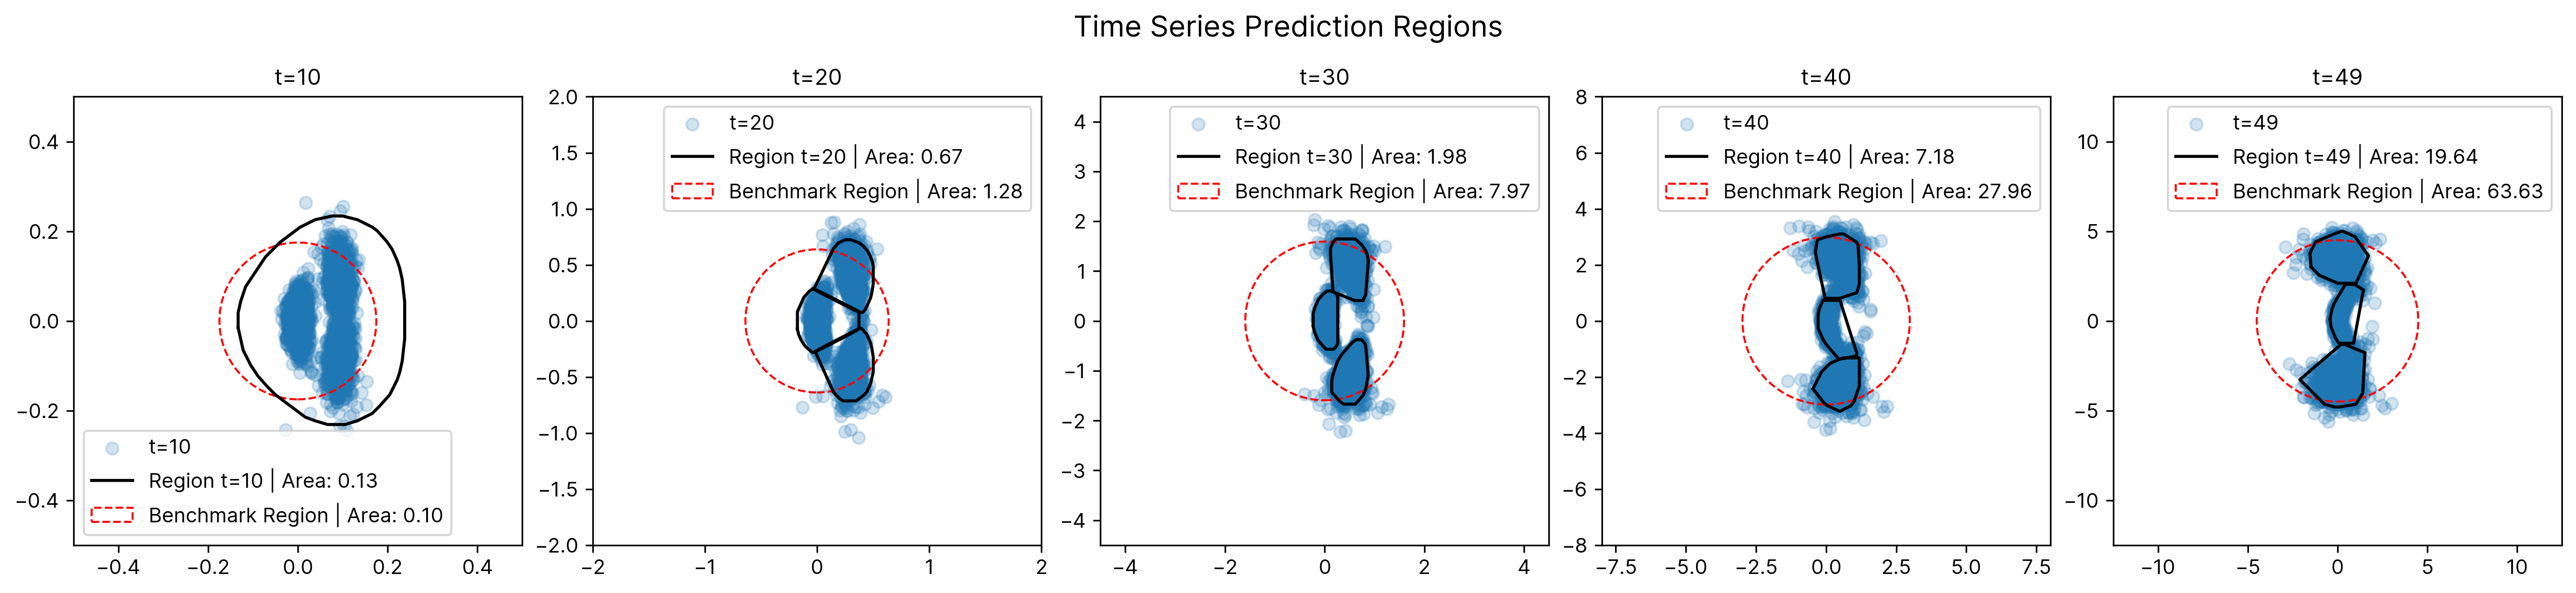

In [26]:
fig, ax = plt.subplots(1, len(TIMESTEPS), constrained_layout=True, figsize=(17.5, 4), dpi=300)

for i, ts in enumerate(TIMESTEPS):
    ax[i].scatter(Z_test[:,i,0], Z_test[:,i,1], alpha=0.2, label=f"t={ts}", color='C0')
    ts_area = 0
    for j, shape_template in enumerate(cvxpcr.cregions[i].shapes):
        ts_area += shape_template.volume()
        if j == len(cvxpcr.cregions[i].shapes) - 1:
            shape_template.plot(ax[i], label=f"Region t={ts} | Area: {ts_area:.2f}")
        else:
            shape_template.plot(ax[i])
    ax[i].set_title(f"t={ts}")
    set_square_aspect_ratio(ax[i], 1.0)
    ax[i].set_xlim([-(2/4)*(i+1)**2, (2/4)*(i+1)**2])
    ax[i].set_ylim([-(2/4)*(i+1)**2, (2/4)*(i+1)**2])
    # bcp_cir = plt.Circle((0,0), bcp_time_weighted_bounds[i], color='red', linestyle='--', fill=False, label=f'Benchmark Region | Area: {np.pi * bcp_time_weighted_bounds[i]**2:.2f}')
    # ax[i].add_patch(bcp_cir)
    # bcp_cir = plt.Circle((0,0), bcp_ratio_weighted_bounds[i], color='orange', linestyle='--', fill=False, label=f'Benchmark Region | Area: {np.pi * bcp_ratio_weighted_bounds[i]**2:.2f}')
    # ax[i].add_patch(bcp_cir)
    bcp_cir = plt.Circle((0,0), bcp_optimized_bounds[i], color='red', linestyle='--', fill=False, label=f'Benchmark Region | Area: {np.pi * bcp_optimized_bounds[i]**2:.2f}')
    ax[i].add_patch(bcp_cir)
    ax[i].legend()

# # Plot benchmark CP region
# bcp_cir = plt.Circle((0,0), bcp_conformal_bound, color='red', linestyle='--', fill=False, label=f'Benchmark Region | Area: {np.pi * bcp_conformal_bound**2:.2f}')
# ax.add_patch(bcp_cir)
# ax.legend()
fig.suptitle(f'Time Series Prediction Regions');


Text(0.5, 0.98, 'Convex Hull Prediction Region for Endpoint')

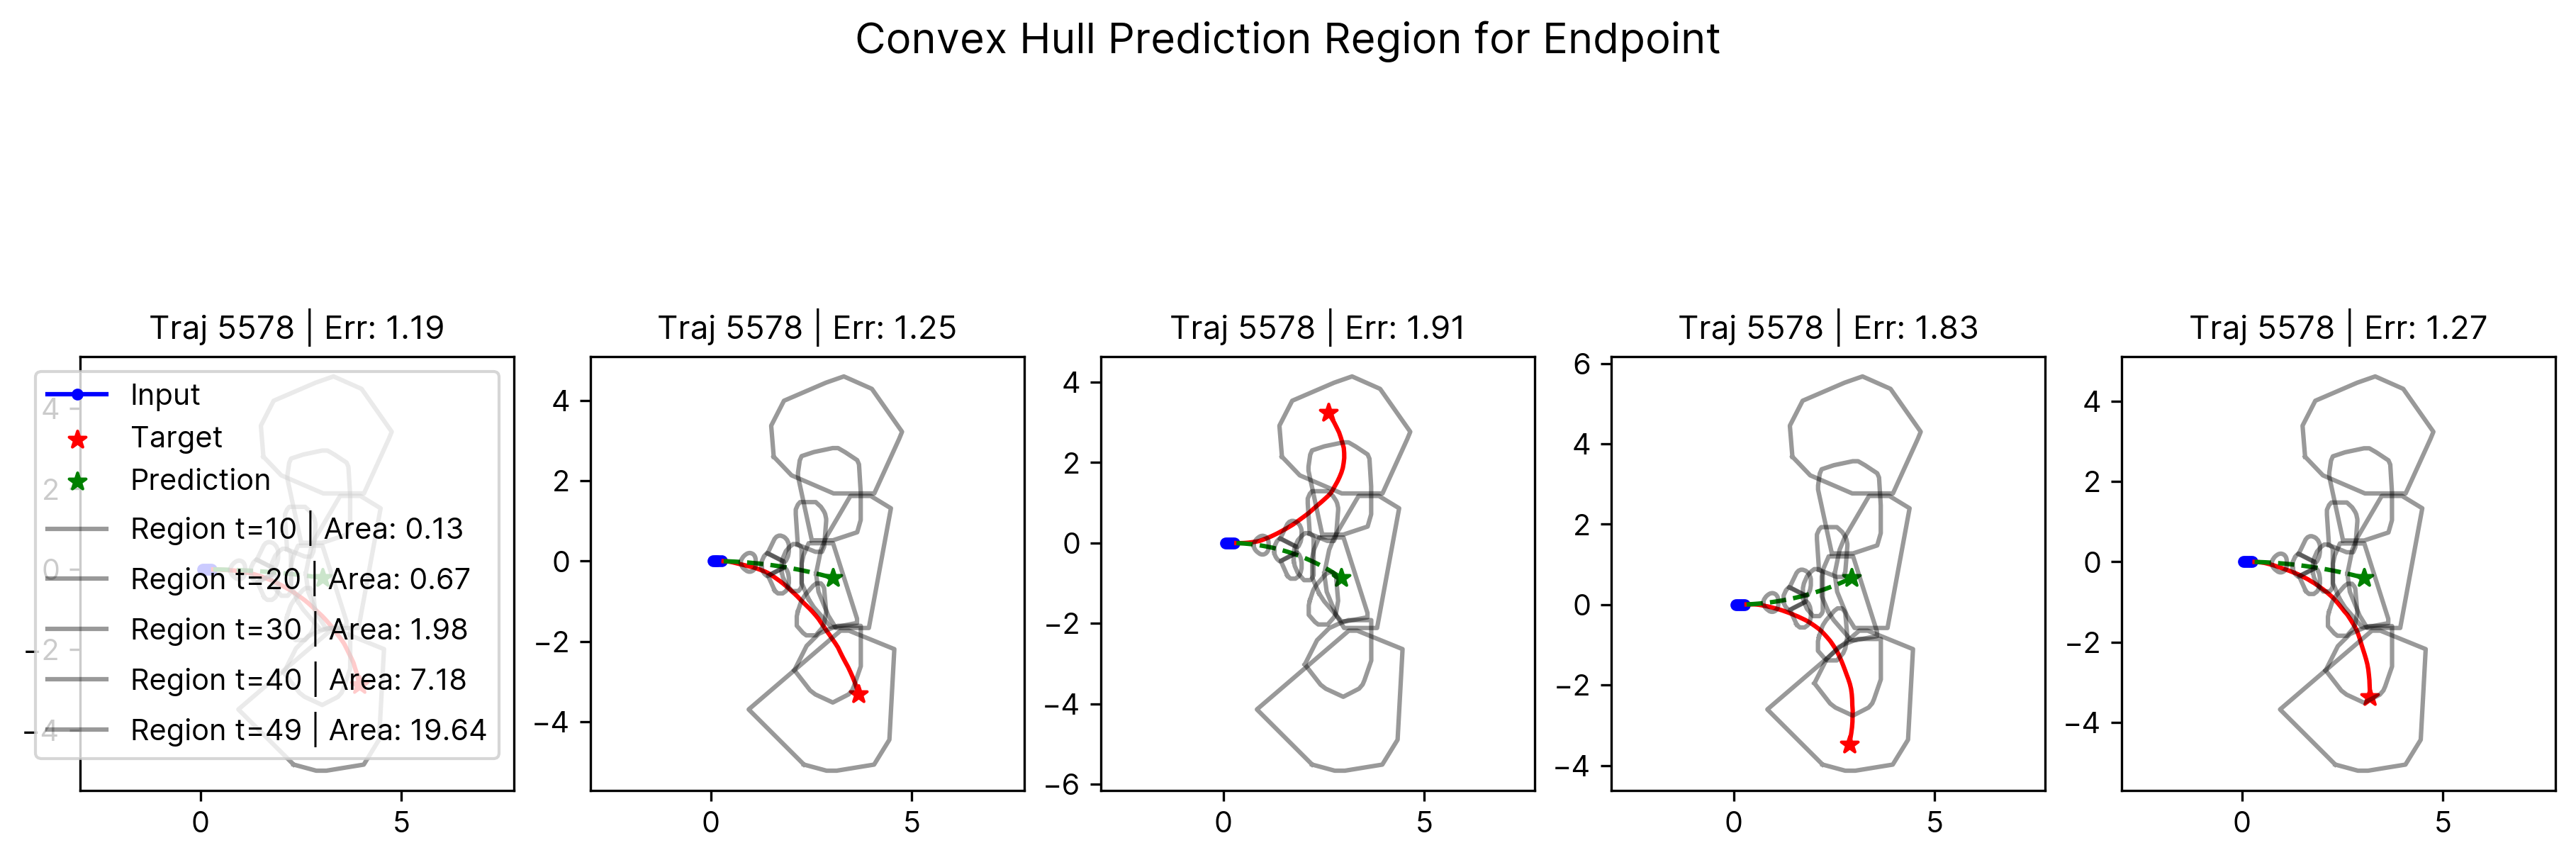

In [27]:
fig, axs = plt.subplots(1, 5, figsize=(12, 5), dpi=300, constrained_layout=True)
for i, ax in enumerate(axs.flat):
    prediction = predictor.predict_trajectory(env_X[INDEX[i]])
    ax.plot(env_X[INDEX[i], :, 0], env_X[INDEX[i], :, 1], 'b.-', label='Input')
    ax.plot(env_Y[INDEX[i], :, 0], env_Y[INDEX[i], :, 1], 'r-')
    ax.scatter(env_Y[INDEX[i], -1, 0], env_Y[INDEX[i], -1, 1], color='r', marker='*', label='Target')
    error = np.linalg.norm(prediction - env_Y[INDEX[i]], axis=1)
    ax.plot(prediction[:, 0], prediction[:, 1], 'g--')
    ax.scatter(prediction[-1, 0], prediction[-1, 1], color='g', marker='*', label='Prediction')
    for i, ts in enumerate(TIMESTEPS):
        ts_area = 0
        for j, shape_template in enumerate(cvxpcr.cregions[i].shapes):
            ts_area += shape_template.volume()
            if j == len(cvxpcr.cregions[i].shapes) - 1:
                shape_template.plot(ax, offset_coords=prediction[ts], label=f"Region t={ts} | Area: {ts_area:.2f}", alpha=0.4)
            else:
                shape_template.plot(ax, offset_coords=prediction[ts], alpha=0.4)


    ax.set_title(f'Traj {INDEX[i]} | Err: {error.mean():.2f}')
    # Plot benchmark CP region
    # bcp_cir = plt.Circle(prediction[-1], bcp_conformal_bound, color='orange', linestyle=':', fill=False, label='Benchmark CP')
    # ax.add_patch(bcp_cir)
    set_square_aspect_ratio(ax)
axs.flat[0].legend()
fig.suptitle('Convex Hull Prediction Region for Endpoint')

  0%|          | 0/1000 [00:00<?, ?it/s]

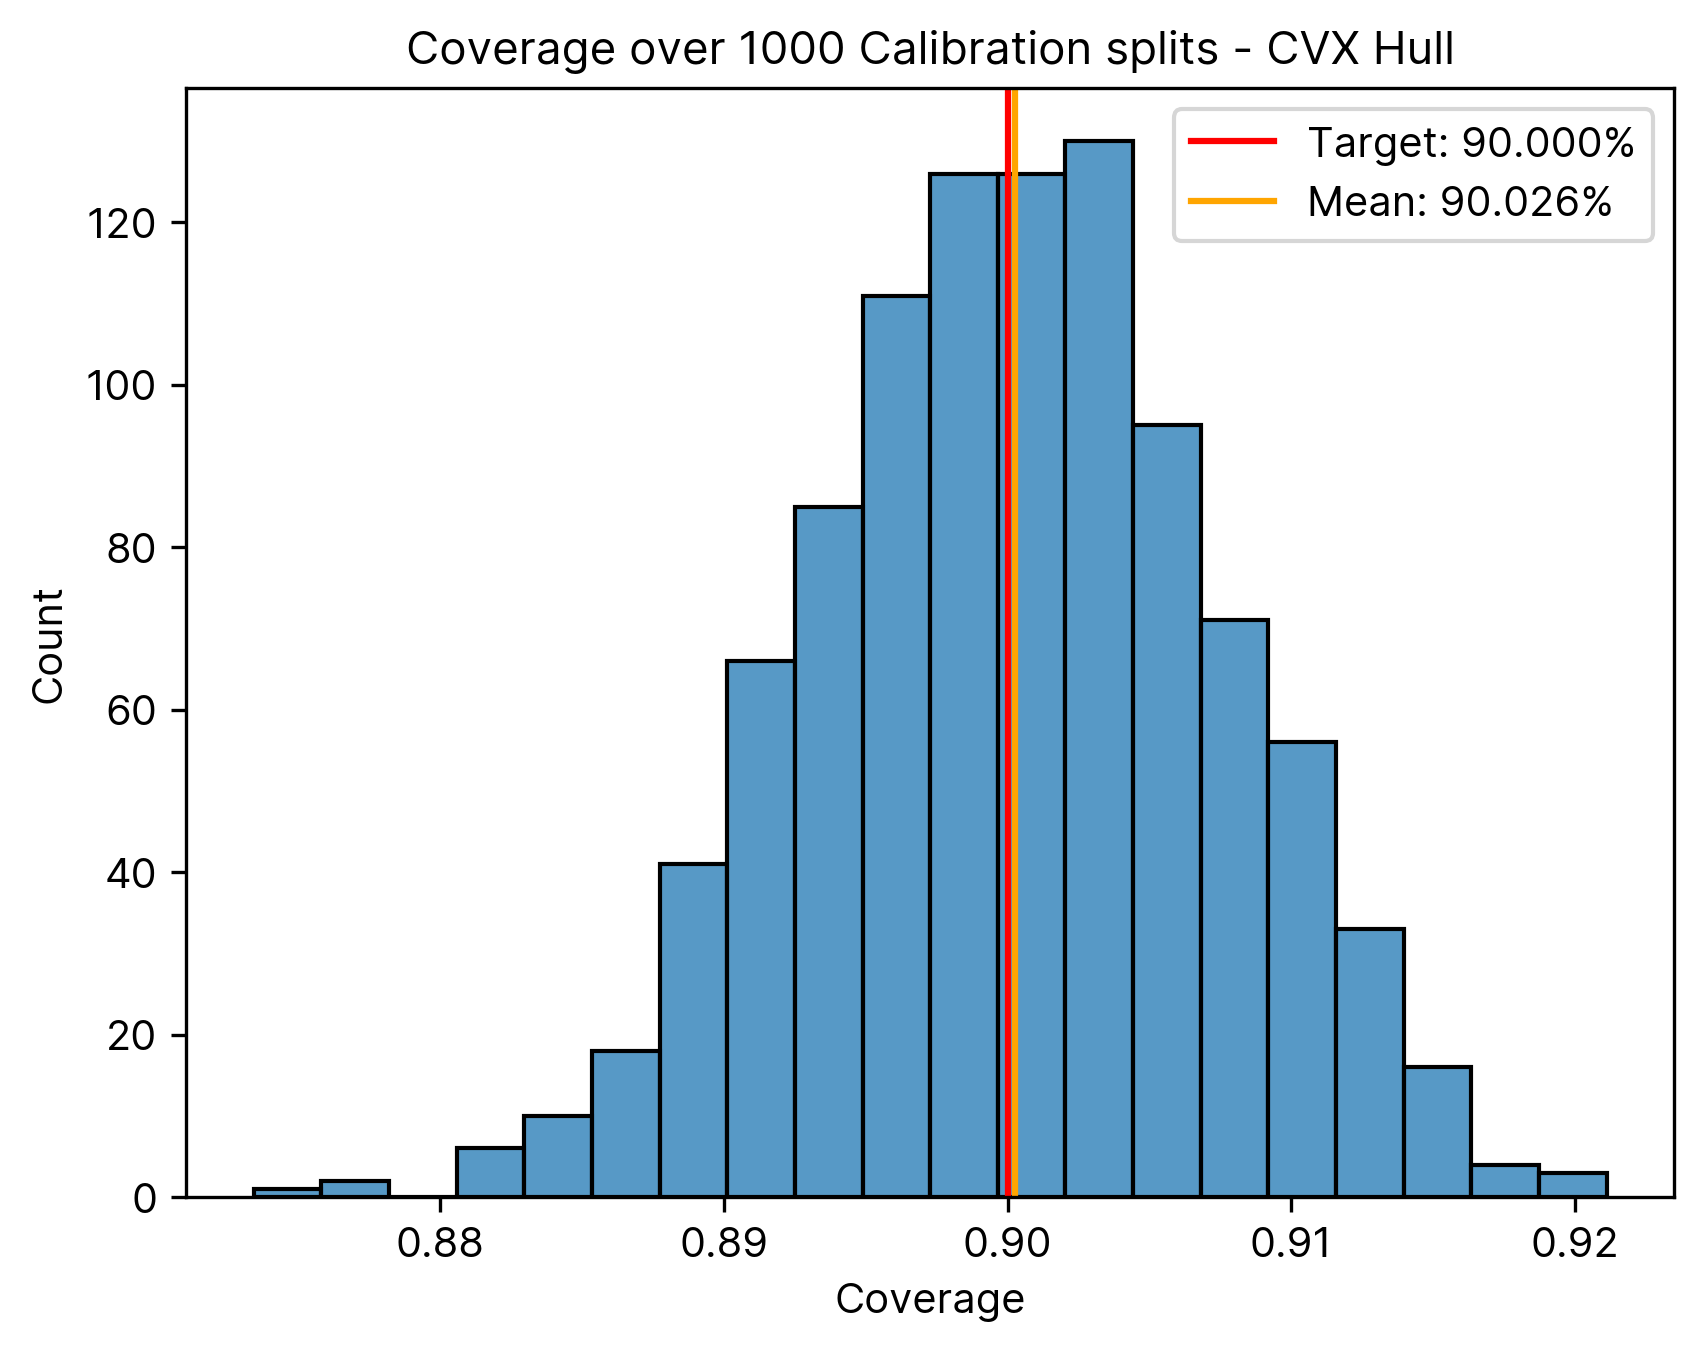

In [28]:
cvxcoverages = shuffle_split_testing(pcr, Z_eval, 1000, 0.5, 42)

sns.histplot(cvxcoverages, bins=20)
plt.axvline(x=DELTA, color="red", label=f"Target: {DELTA:.3%}")
plt.axvline(x=np.mean(cvxcoverages), color="orange", label=f"Mean: {np.mean(cvxcoverages):.3%}")
plt.title("Coverage over 1000 Calibration splits - CVX Hull")
plt.xlabel("Coverage")
plt.ylabel("Count")
plt.legend()

## Hyperrectangle

In [29]:
de = KDE(grid_size=150, bw_factor=BW_FACTOR)
pcr = ConformalRegionTimeSeries(len(TIMESTEPS), de, "meanshift", "hyperrectangle", DELTA)
pcr.fit(Z_cal_one)
pcr.conformalize(Z_cal_two)
hrcpcr = pcr

Total Weight Sum: 0.9740968701945676
Total Weight Sum: 0.9867110802467438
Total Weight Sum: 0.9867111111110802
Total Weight Sum: 0.9867111228868551
Total Weight Sum: 0.9865266700675144


Test Coverage:  0.904619076184763


Text(0.5, 0.98, 'Target Coverage: 0.90 | Test Coverage: 0.90')

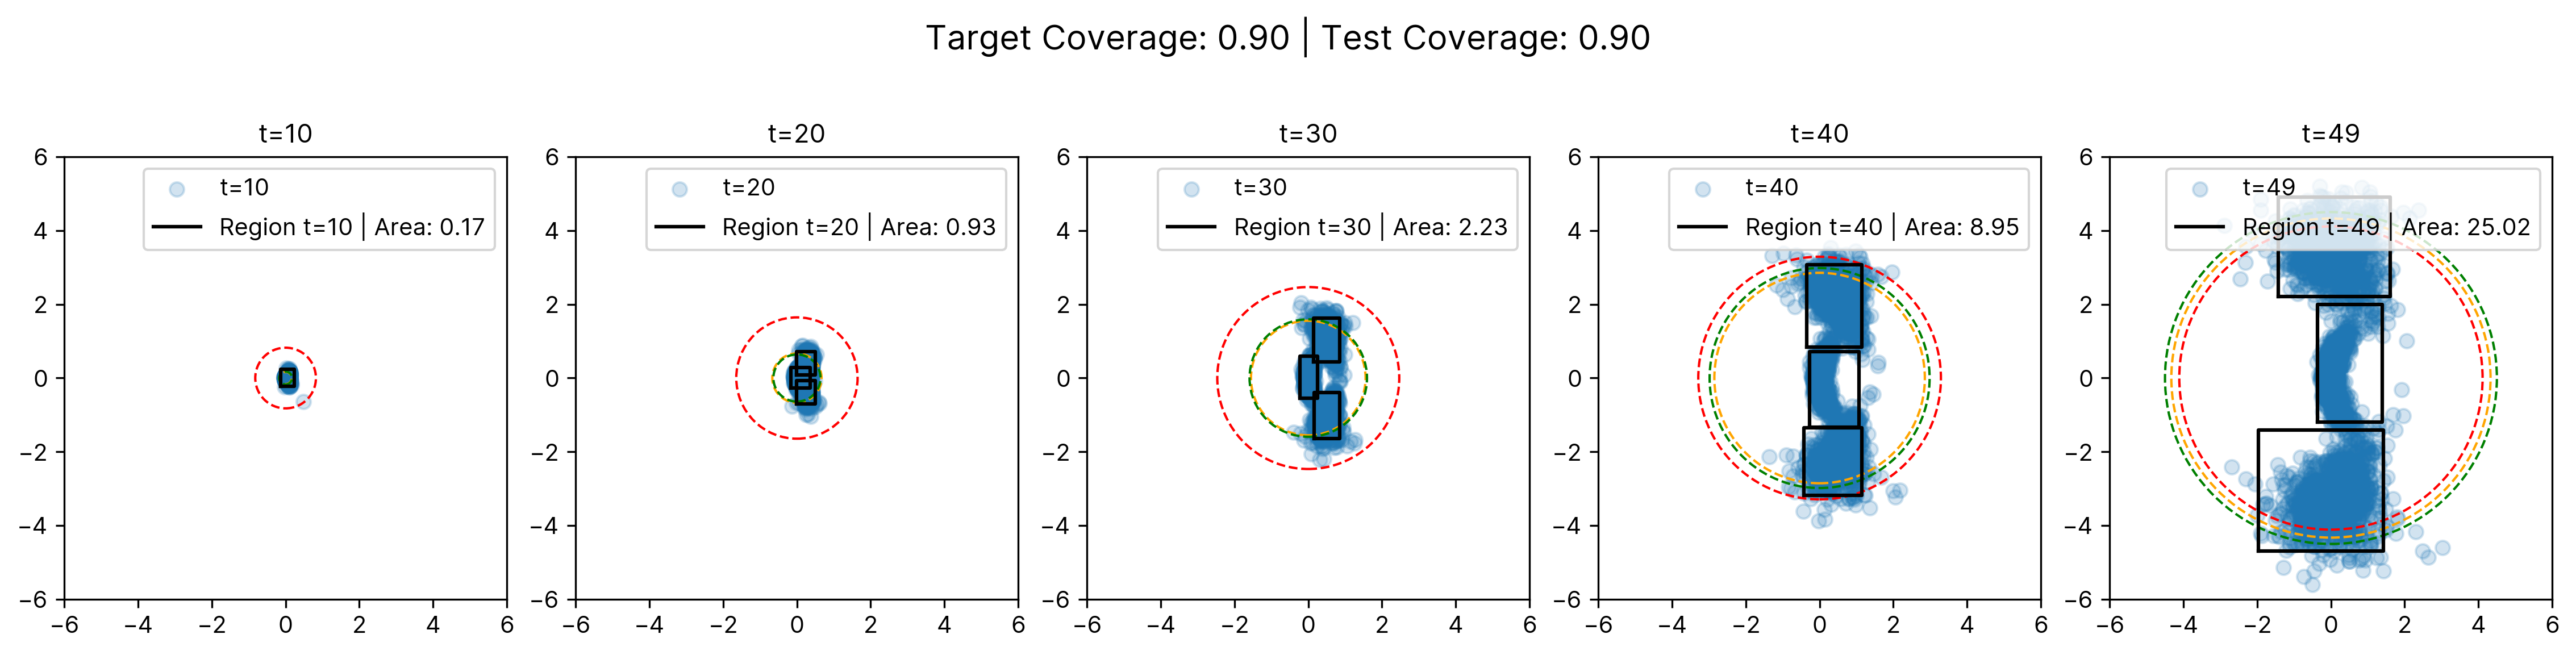

In [30]:
scores = hrcpcr.calculate_scores(Z_test)
coverage = np.sum(scores < 0) / len(scores)
print("Test Coverage: ", coverage)
hrc_coverage = coverage

fig, ax = plt.subplots(1, len(TIMESTEPS), constrained_layout=True, figsize=(15, 4), dpi=300)
for i, ts in enumerate(TIMESTEPS):
    ax[i].scatter(Z_test[:,i,0], Z_test[:,i,1], alpha=0.2, label=f"t={ts}")
    ts_area = 0
    for j, shape_template in enumerate(hrcpcr.cregions[i].shapes):
        ts_area += shape_template.volume()
        if j == len(hrcpcr.cregions[i].shapes) - 1:
            shape_template.plot(ax[i], label=f"Region t={ts} | Area: {ts_area:.2f}")
        else:
            shape_template.plot(ax[i])
    ax[i].set_title(f"t={ts}")
    ax[i].legend()
    set_square_aspect_ratio(ax[i])
    ax[i].set_xlim([-6, 6])
    ax[i].set_ylim([-6, 6])
    bcp_cir = plt.Circle((0,0), bcp_time_weighted_bounds[i], color='red', linestyle='--', fill=False, label=f'Benchmark Region | Area: {np.pi * bcp_time_weighted_bounds[i]**2:.2f}')
    ax[i].add_patch(bcp_cir)
    bcp_cir = plt.Circle((0,0), bcp_ratio_weighted_bounds[i], color='orange', linestyle='--', fill=False, label=f'Benchmark Region | Area: {np.pi * bcp_ratio_weighted_bounds[i]**2:.2f}')
    ax[i].add_patch(bcp_cir)
    bcp_cir = plt.Circle((0,0), bcp_optimized_bounds[i], color='green', linestyle='--', fill=False, label=f'Benchmark Region | Area: {np.pi * bcp_optimized_bounds[i]**2:.2f}')
    ax[i].add_patch(bcp_cir)
# # Plot benchmark CP region
# bcp_cir = plt.Circle((0,0), bcp_conformal_bound, color='red', linestyle='--', fill=False, label=f'Benchmark Region | Area: {np.pi * bcp_conformal_bound**2:.2f}')
# ax.add_patch(bcp_cir)
# ax.legend()
fig.suptitle(f'Target Coverage: {DELTA:.2f} | Test Coverage: {coverage:.2f}')


Text(0.5, 0.98, 'Hyperrectangle Prediction Region for Endpoint')

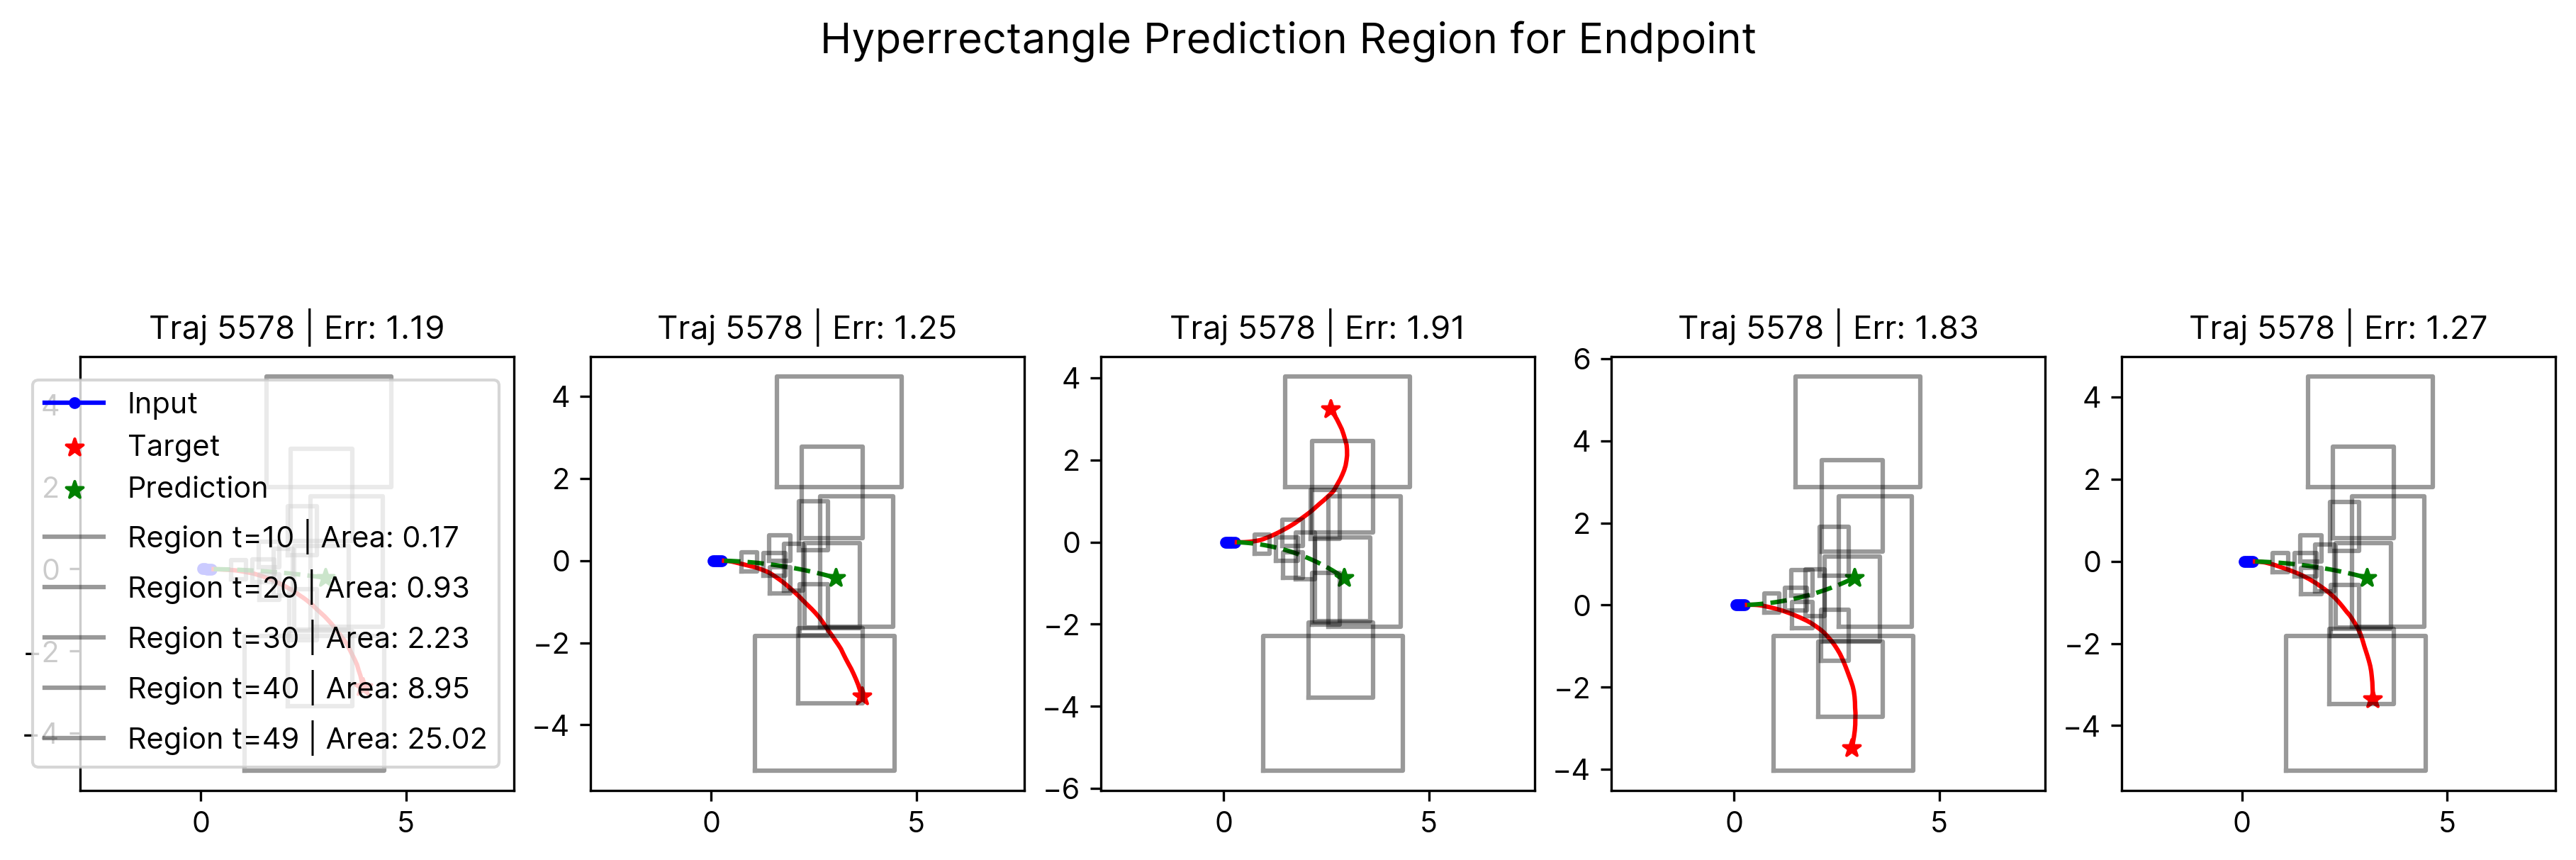

In [31]:
fig, axs = plt.subplots(1, 5, figsize=(12, 5), dpi=300, constrained_layout=True)
for i, ax in enumerate(axs.flat):
    prediction = predictor.predict_trajectory(env_X[INDEX[i]])
    ax.plot(env_X[INDEX[i], :, 0], env_X[INDEX[i], :, 1], 'b.-', label='Input')
    ax.plot(env_Y[INDEX[i], :, 0], env_Y[INDEX[i], :, 1], 'r-')
    ax.scatter(env_Y[INDEX[i], -1, 0], env_Y[INDEX[i], -1, 1], color='r', marker='*', label='Target')
    error = np.linalg.norm(prediction - env_Y[INDEX[i]], axis=1)
    ax.plot(prediction[:, 0], prediction[:, 1], 'g--')
    ax.scatter(prediction[-1, 0], prediction[-1, 1], color='g', marker='*', label='Prediction')
    for i, ts in enumerate(TIMESTEPS):
        ts_area = 0
        for j, shape_template in enumerate(hrcpcr.cregions[i].shapes):
            ts_area += shape_template.volume()
            if j == len(hrcpcr.cregions[i].shapes) - 1:
                shape_template.plot(ax, offset_coords=prediction[ts], label=f"Region t={ts} | Area: {ts_area:.2f}", alpha=0.4)
            else:
                shape_template.plot(ax, offset_coords=prediction[ts], alpha=0.4)


    ax.set_title(f'Traj {INDEX[i]} | Err: {error.mean():.2f}')
    # Plot benchmark CP region
    # bcp_cir = plt.Circle(prediction[-1], bcp_conformal_bound, color='orange', linestyle=':', fill=False, label='Benchmark CP')
    # ax.add_patch(bcp_cir)
    set_square_aspect_ratio(ax)
axs.flat[0].legend()
fig.suptitle('Hyperrectangle Prediction Region for Endpoint')

  0%|          | 0/1000 [00:00<?, ?it/s]

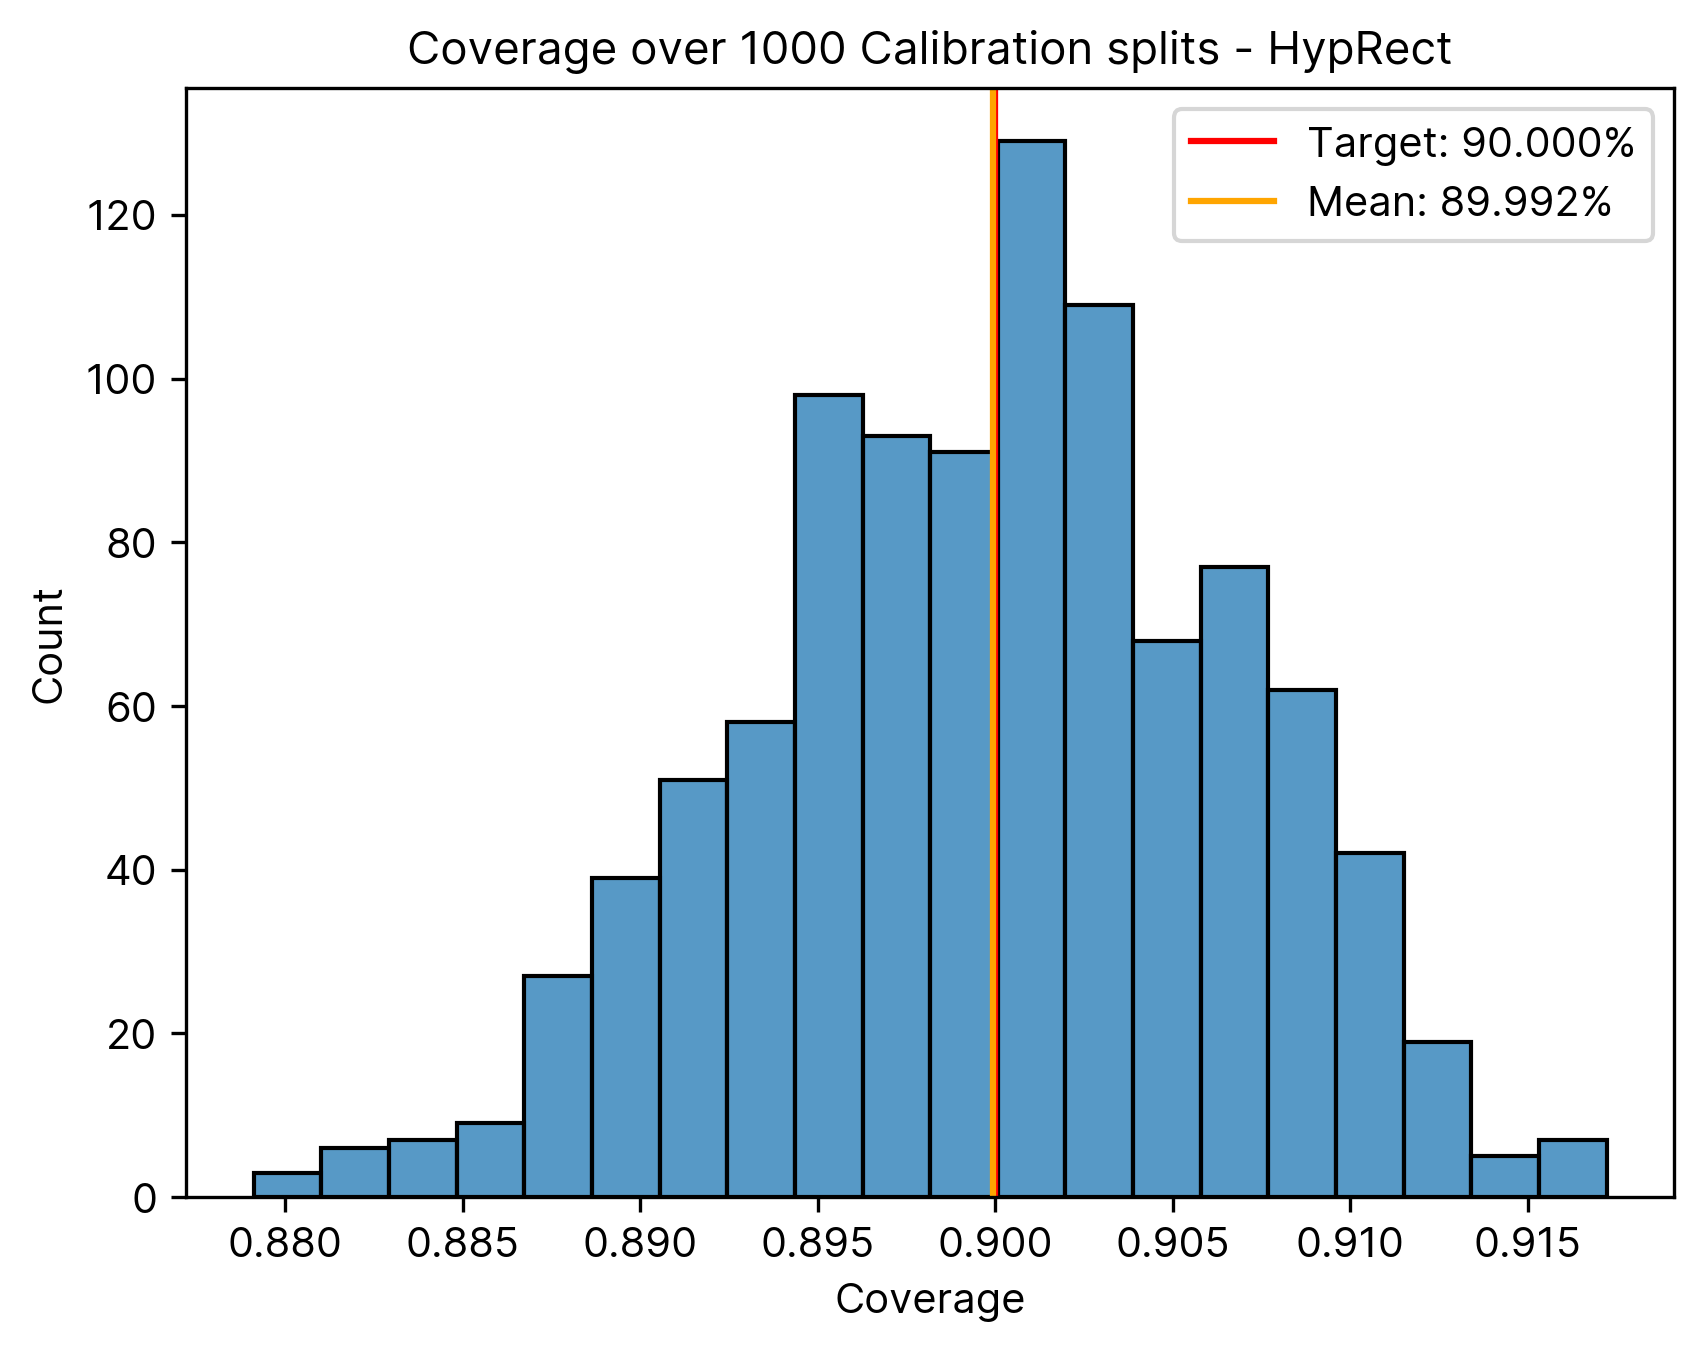

In [32]:
hrccoverages = shuffle_split_testing(pcr, Z_eval, 1000, 0.5, 42)
sns.histplot(hrccoverages, bins=20)
plt.axvline(x=DELTA, color="red", label=f"Target: {DELTA:.3%}")
plt.axvline(x=np.mean(hrccoverages), color="orange", label=f"Mean: {np.mean(hrccoverages):.3%}")
plt.title("Coverage over 1000 Calibration splits - HypRect")
plt.xlabel("Coverage")
plt.ylabel("Count")
plt.legend()

## Ellipsoid

In [33]:
de = KDE(grid_size=150, bw_factor=BW_FACTOR)
pcr = ConformalRegionTimeSeries(len(TIMESTEPS), de, "meanshift", "ellipse", DELTA)
pcr.fit(Z_cal_one)
pcr.conformalize(Z_cal_two)
ellpcr = pcr
# print(pcr.time_normalizing_constant)

Total Weight Sum: 0.9740968701945676
Total Weight Sum: 0.9867110802467438
Total Weight Sum: 0.9867111111110802
Total Weight Sum: 0.9867111228868551
Total Weight Sum: 0.9865266700675144


In [34]:
for shape in pcr.cregions:
    shape.print_times()

DE time             : 3.1604363918304443
CL time             : 2.327939033508301
ST time             : 1.2697103023529053
Score time          : 0.0005588531494140625
Total time          : 6.7586445808410645
DE time             : 1.8816449642181396
CL time             : 1.5944812297821045
ST time             : 2.758591651916504
Score time          : 0.001130819320678711
Total time          : 6.235848665237427
DE time             : 0.9676480293273926
CL time             : 0.5263254642486572
ST time             : 2.714203119277954
Score time          : 0.001260995864868164
Total time          : 4.209437608718872
DE time             : 1.007444143295288
CL time             : 0.5265905857086182
ST time             : 3.0928025245666504
Score time          : 0.001262664794921875
Total time          : 4.6280999183654785
DE time             : 1.0441176891326904
CL time             : 0.5141782760620117
ST time             : 4.6768107414245605
Score time          : 0.0011627674102783203
Total time

In [35]:
6.7586445808410645+6.235848665237427+4.209437608718872+4.6280999183654785+6.236269474029541

28.068300247192383

In [36]:
import time
start = time.time()
scores = pcr.calculate_scores(Z_test)
end = time.time()
print(end - start)

0.008371591567993164


Test Coverage:  0.9037192561487702


Text(0.5, 0.98, 'Time Series Prediction Regions')

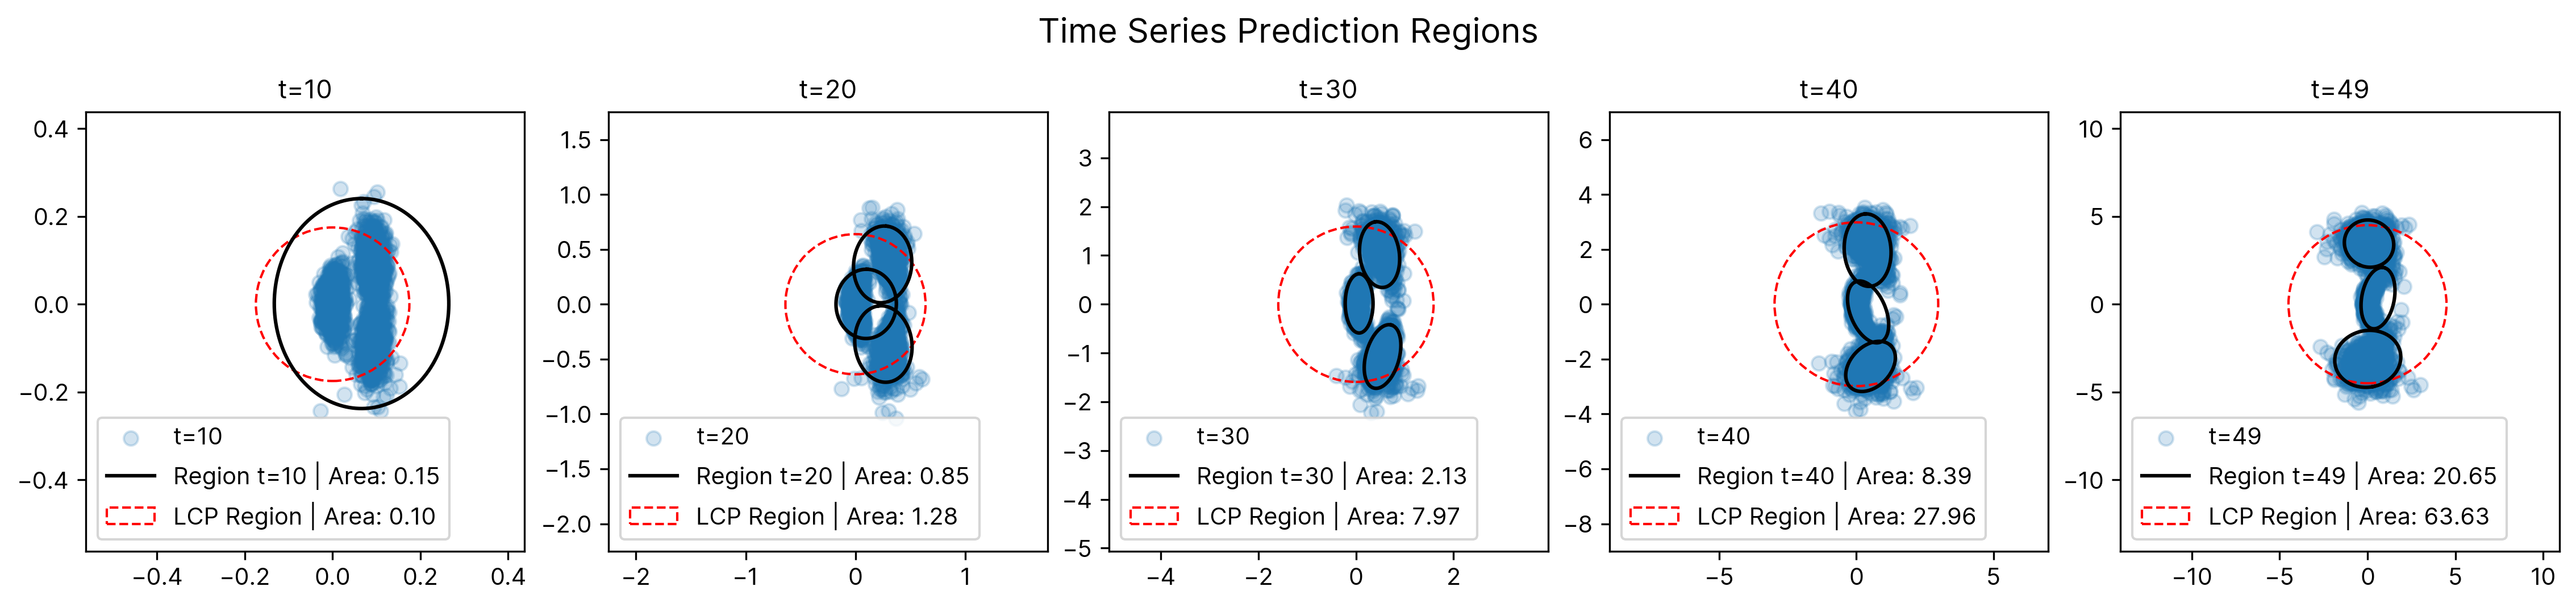

In [34]:
scores = ellpcr.calculate_scores(Z_test)
coverage = np.sum(scores < 0) / len(scores)
print("Test Coverage: ", coverage)
ell_coverage = coverage

fig, ax = plt.subplots(1, len(TIMESTEPS), constrained_layout=True, figsize=(15, 3.5), dpi=300)
for i, ts in enumerate(TIMESTEPS):
    ax[i].scatter(Z_test[:,i,0], Z_test[:,i,1], alpha=0.2, label=f"t={ts}")
    ts_area = 0
    for j, shape_template in enumerate(ellpcr.cregions[i].shapes):
        ts_area += shape_template.volume()
        if j == len(ellpcr.cregions[i].shapes) - 1:
            shape_template.plot(ax[i], label=f"Region t={ts} | Area: {ts_area:.2f}")
        else:
            shape_template.plot(ax[i])
    ax[i].set_title(f"t={ts}")
    set_square_aspect_ratio(ax[i])
    ax[i].set_xlim([-(2.25/4)*(i+1)**2, (1.75/4)*(i+1)**2])
    ax[i].set_ylim([-(2.25/4)*(i+1)**2, (1.75/4)*(i+1)**2])
    # bcp_cir = plt.Circle((0,0), bcp_time_weighted_bounds[i], color='red', linestyle='--', fill=False, label=f'Benchmark Region | Area: {np.pi * bcp_time_weighted_bounds[i]**2:.2f}')
    # ax[i].add_patch(bcp_cir)
    # bcp_cir = plt.Circle((0,0), bcp_ratio_weighted_bounds[i], color='orange', linestyle='--', fill=False, label=f'Benchmark Region | Area: {np.pi * bcp_ratio_weighted_bounds[i]**2:.2f}')
    # ax[i].add_patch(bcp_cir)
    bcp_cir = plt.Circle((0,0), bcp_optimized_bounds[i], color='red', linestyle='--', fill=False, label=f'LCP Region | Area: {np.pi * bcp_optimized_bounds[i]**2:.2f}')
    ax[i].add_patch(bcp_cir)
    ax[i].legend(loc="lower left")
# # Plot benchmark CP region
# bcp_cir = plt.Circle((0,0), bcp_conformal_bound, color='red', linestyle='--', fill=False, label=f'Benchmark Region | Area: {np.pi * bcp_conformal_bound**2:.2f}')
# ax.add_patch(bcp_cir)
# ax.legend()
fig.suptitle(f'Time Series Prediction Regions')

Text(0.5, 0.98, 'Ellipsoid Prediction Region for Endpoint')

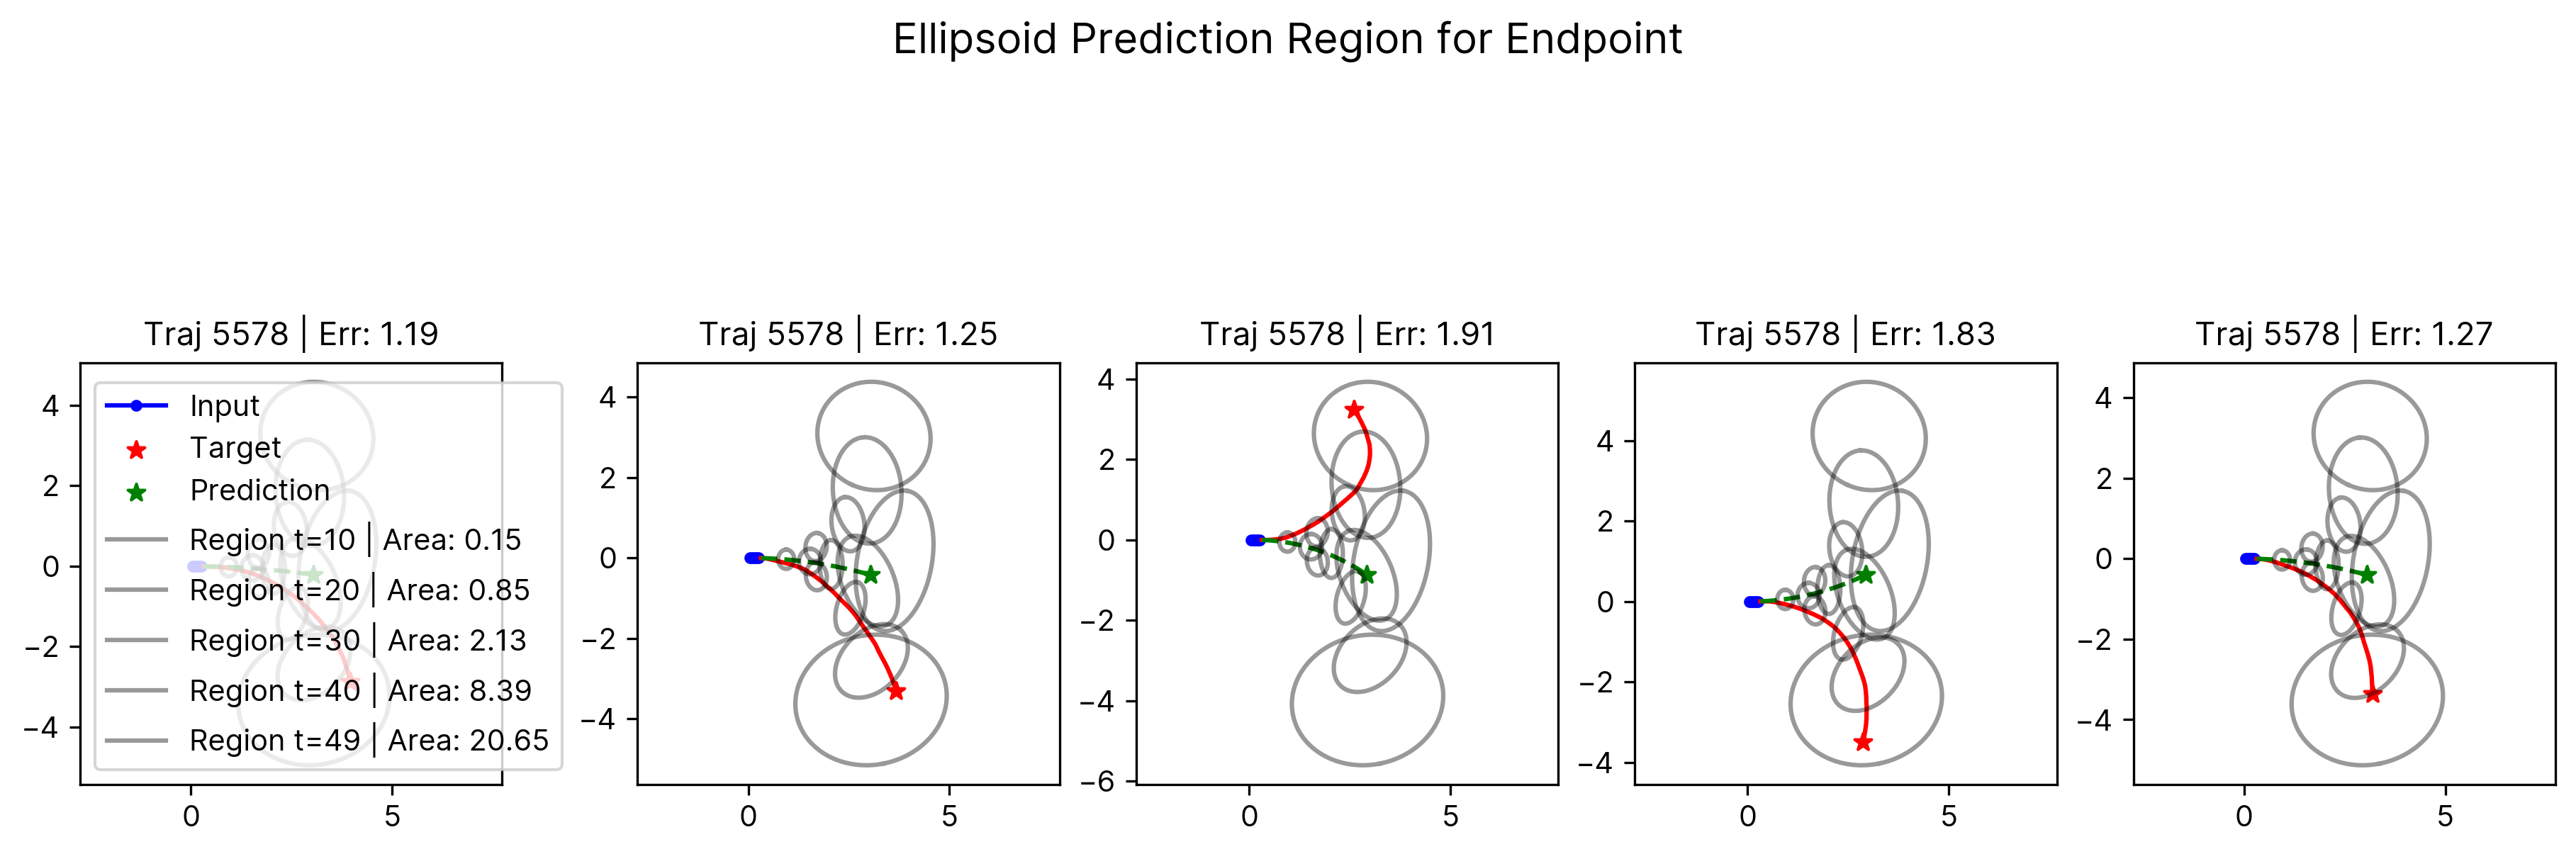

In [35]:
fig, axs = plt.subplots(1, 5, figsize=(12, 5), dpi=300, constrained_layout=True)
for i, ax in enumerate(axs.flat):
    prediction = predictor.predict_trajectory(env_X[INDEX[i]])
    ax.plot(env_X[INDEX[i], :, 0], env_X[INDEX[i], :, 1], 'b.-', label='Input')
    ax.plot(env_Y[INDEX[i], :, 0], env_Y[INDEX[i], :, 1], 'r-')
    ax.scatter(env_Y[INDEX[i], -1, 0], env_Y[INDEX[i], -1, 1], color='r', marker='*', label='Target')
    error = np.linalg.norm(prediction - env_Y[INDEX[i]], axis=1)
    ax.plot(prediction[:, 0], prediction[:, 1], 'g--')
    ax.scatter(prediction[-1, 0], prediction[-1, 1], color='g', marker='*', label='Prediction')
    for i, ts in enumerate(TIMESTEPS):
        ts_area = 0
        for j, shape_template in enumerate(ellpcr.cregions[i].shapes):
            ts_area += shape_template.volume()
            if j == len(ellpcr.cregions[i].shapes) - 1:
                shape_template.plot(ax, offset_coords=prediction[ts], label=f"Region t={ts} | Area: {ts_area:.2f}", alpha=0.4)
            else:
                shape_template.plot(ax, offset_coords=prediction[ts], alpha=0.4)


    ax.set_title(f'Traj {INDEX[i]} | Err: {error.mean():.2f}')
    # Plot benchmark CP region
    # bcp_cir = plt.Circle(prediction[-1], bcp_conformal_bound, color='orange', linestyle=':', fill=False, label='Benchmark CP')
    # ax.add_patch(bcp_cir)
    set_square_aspect_ratio(ax)
axs.flat[0].legend()
fig.suptitle('Ellipsoid Prediction Region for Endpoint')

  0%|          | 0/1000 [00:00<?, ?it/s]

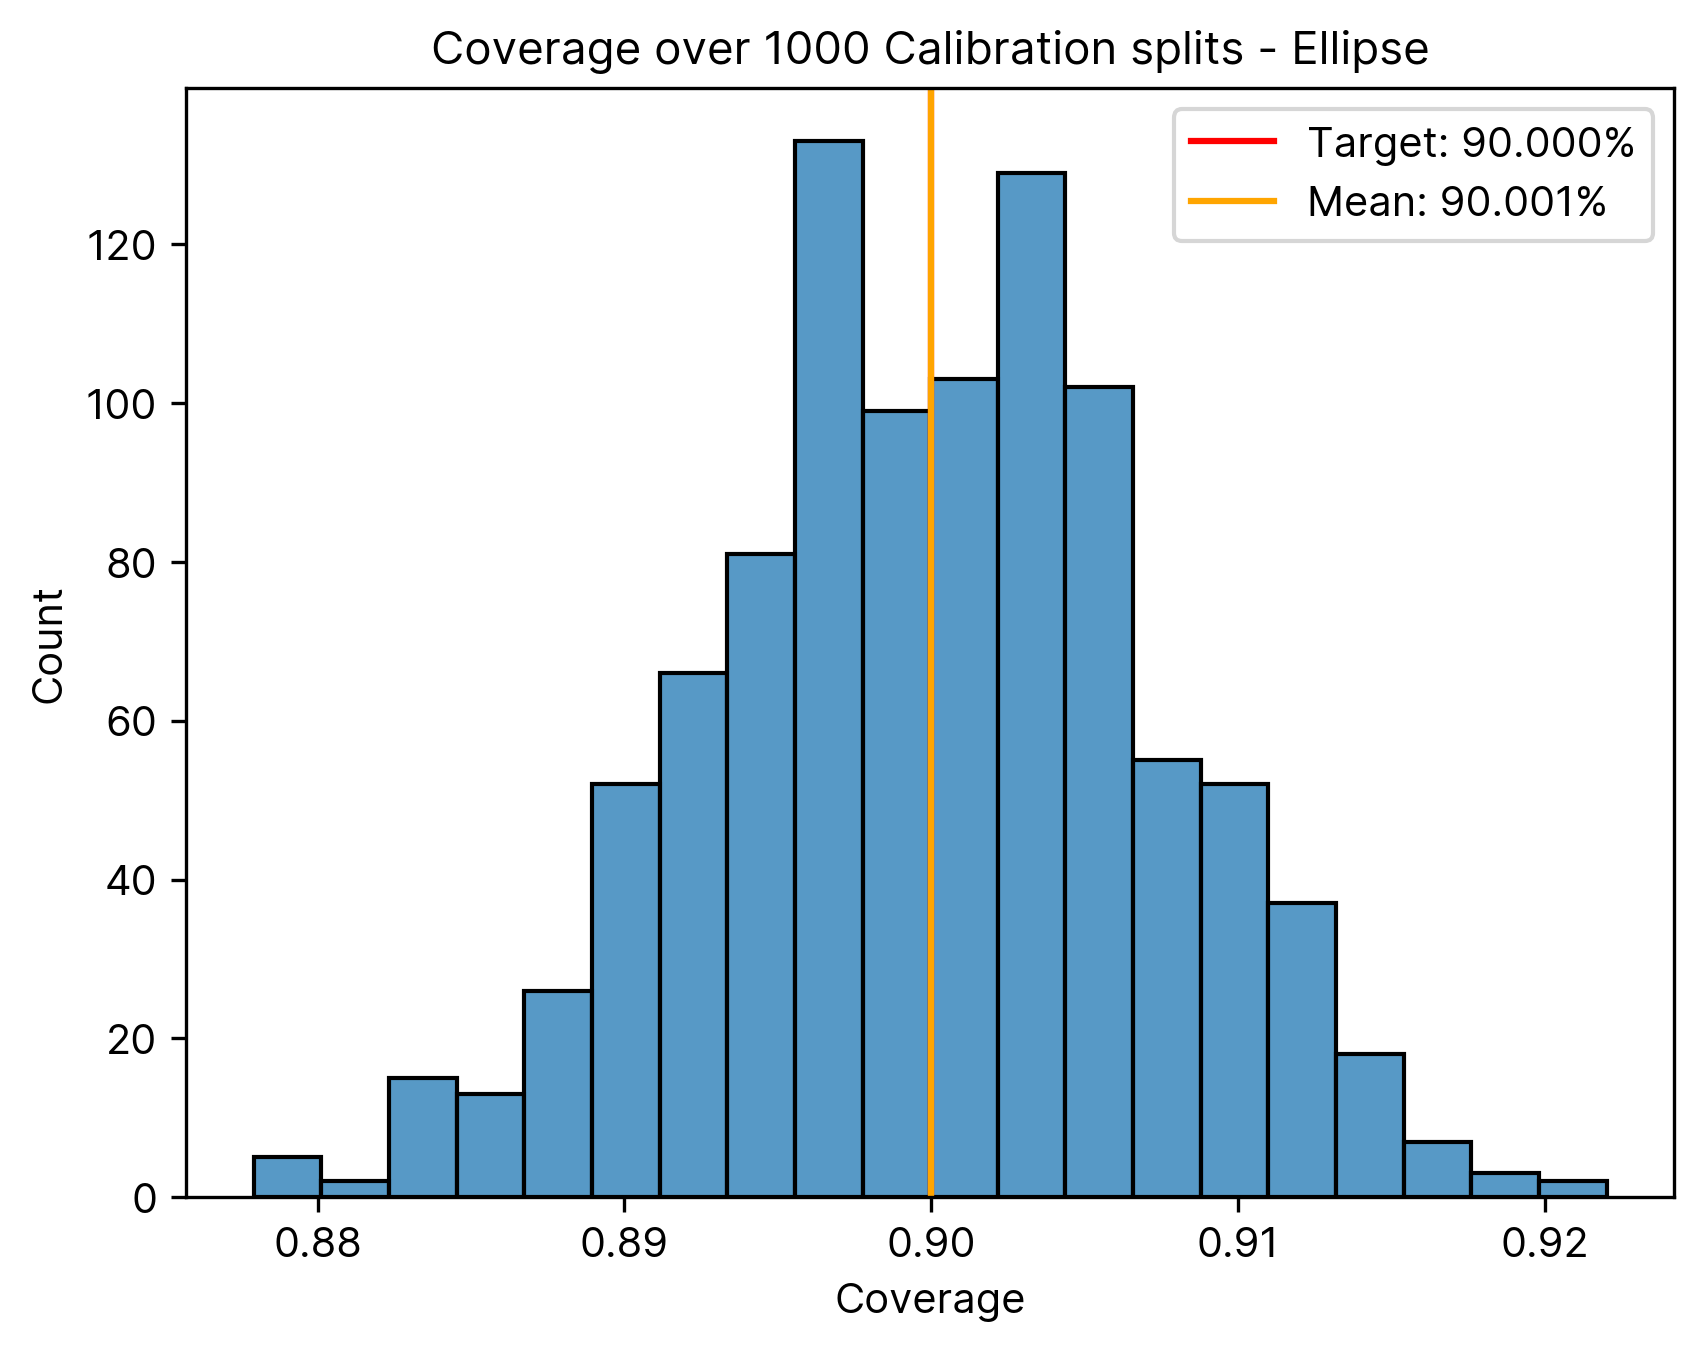

In [36]:
ellcoverages = shuffle_split_testing(pcr, Z_eval, 1000, 0.5, 42)
sns.histplot(ellcoverages, bins=20)
plt.axvline(x=DELTA, color="red", label=f"Target: {DELTA:.3%}")
plt.axvline(x=np.mean(ellcoverages), color="orange", label=f"Mean: {np.mean(ellcoverages):.3%}")
plt.title("Coverage over 1000 Calibration splits - Ellipse")
plt.xlabel("Coverage")
plt.ylabel("Count")
plt.legend()

NameError: name 'bcp_conformal_bound' is not defined

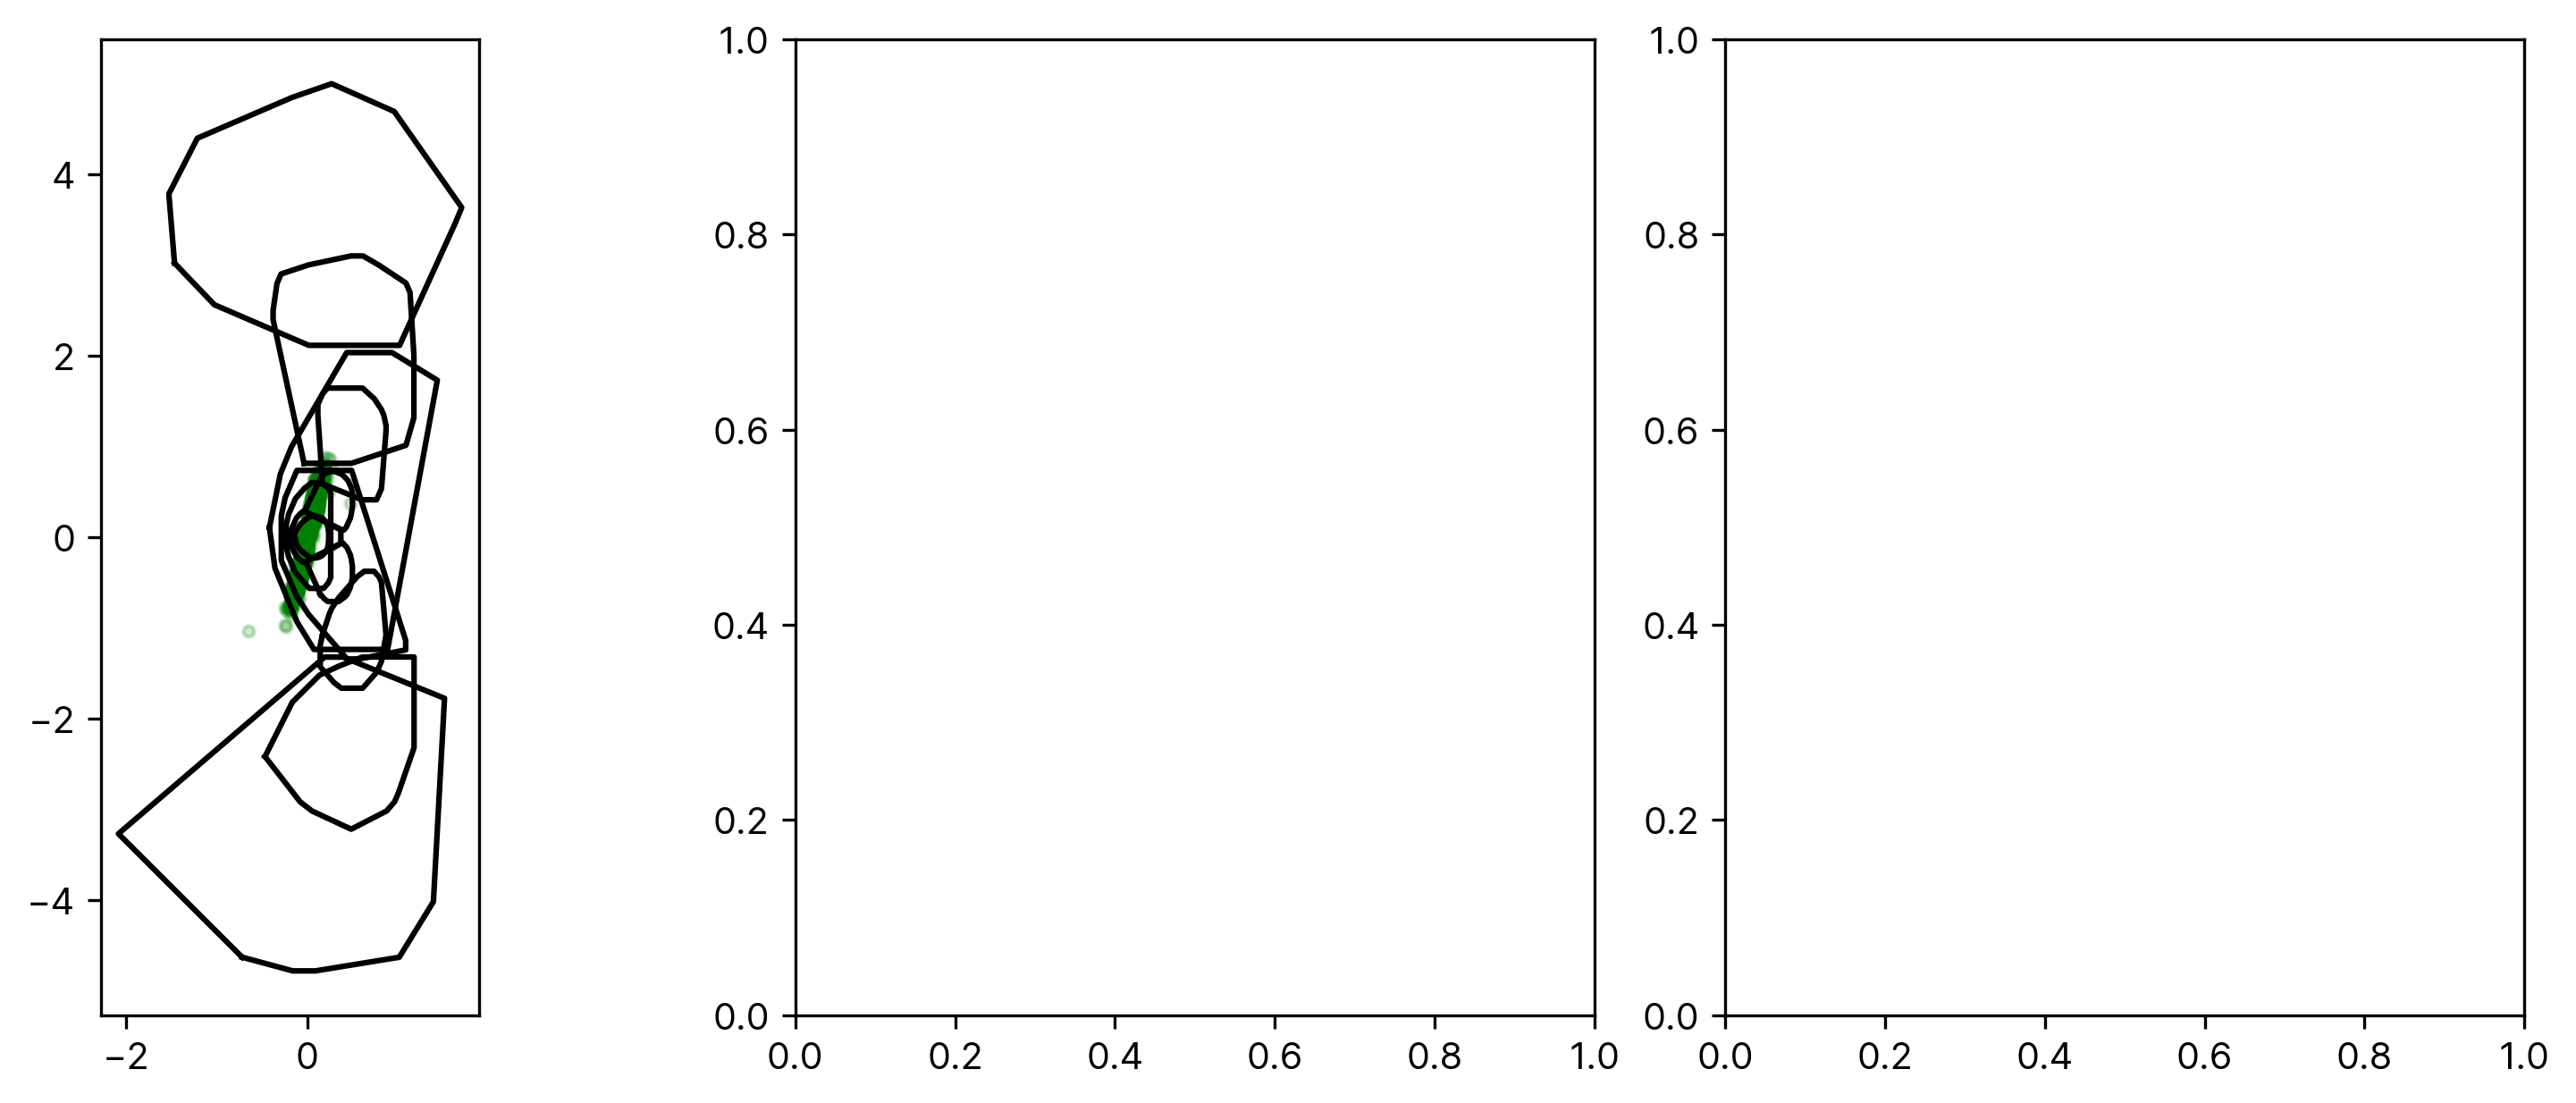

In [37]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4), constrained_layout=True)
# On the first plot, show the convex hull
#ax.scatter(Z_cal_two[:, 0], Z_cal_two[:, 1], color="blue", marker=".", label="$D_{cal,2}$", alpha=0.2)
axs[0].scatter(Z_test[:, 0], Z_test[:, 1], color="green", marker=".", label="$Z_{\\text{test}}$", alpha=0.2)
axs[0].set_aspect("equal")
total_area = 0
for i, shape_template in enumerate(cvxpcr.shapes):
    total_area += shape_template.volume()
    if i == len(cvxpcr.shapes) - 1:
        shape_template.plot(axs[0], label="$S_{{CP}}$ | Area: {:.2f}".format(total_area))
    else:
        shape_template.plot(axs[0])
# Plot benchmark CP region
bcp_cir = plt.Circle((0,0), bcp_conformal_bound, color='red', linestyle='--', fill=False, label=f'$S_{{\\text{{benchmark}}}}$ | Area: {np.pi * bcp_conformal_bound**2:.2f}')
axs[0].add_patch(bcp_cir)
axs[0].legend(bbox_to_anchor=(0.5, -0.4), loc='lower center', borderaxespad=0.)
set_square_aspect_ratio(axs[0])
axs[0].set_title('Convex Hull Prediction Regions')

axs[1].scatter(Z_test[:, 0], Z_test[:, 1], color="green", marker=".", label="$Z_{\\text{test}}$", alpha=0.2)
axs[1].set_aspect("equal")
total_area = 0
for i, shape_template in enumerate(hrcpcr.shapes):
    total_area += shape_template.volume()
    if i == len(hrcpcr.shapes) - 1:
        shape_template.plot(axs[1], label="$S_{{CP}}$ | Area: {:.2f}".format(total_area))
    else:
        shape_template.plot(axs[1])
# Plot benchmark CP region
bcp_cir = plt.Circle((0,0), bcp_conformal_bound, color='red', linestyle='--', fill=False, label=f'$S_{{\\text{{benchmark}}}}$ | Area: {np.pi * bcp_conformal_bound**2:.2f}')
axs[1].add_patch(bcp_cir)
axs[1].legend(bbox_to_anchor=(0.5, -0.4), loc='lower center', borderaxespad=0.)
set_square_aspect_ratio(axs[1])
axs[1].set_title('Hyperrectangle Prediction Regions')

axs[2].scatter(Z_test[:, 0], Z_test[:, 1], color="green", marker=".", label="$Z_{\\text{test}}$", alpha=0.2)
axs[2].set_aspect("equal")
total_area = 0
for i, shape_template in enumerate(ellpcr.shapes):
    total_area += shape_template.volume()
    if i == len(ellpcr.shapes) - 1:
        shape_template.plot(axs[2], label="$S_{{CP}}$ | Area: {:.2f}".format(total_area))
    else:
        shape_template.plot(axs[2])
# Plot benchmark CP region
bcp_cir = plt.Circle((0,0), bcp_conformal_bound, color='red', linestyle='--', fill=False, label=f'$S_{{\\text{{benchmark}}}}$ | Area: {np.pi * bcp_conformal_bound**2:.2f}')
axs[2].add_patch(bcp_cir)
axs[2].legend(bbox_to_anchor=(0.5, -0.4), loc='lower center', borderaxespad=0.)
axs[2].set_title('Ellipsoid Prediction Regions')
set_square_aspect_ratio(axs[2])

fig.suptitle("Vehicle Trajectory Prediction Regions")

In [ ]:
fig = plt.figure(figsize=(10, 3.5))
from matplotlib import gridspec
gs = gridspec.GridSpec(1,10)
ax1 = plt.subplot(gs[0, :6])
ax2 = plt.subplot(gs[0, 6:])

sns.histplot(cvxcoverages, element="poly", label="Convex Hull", alpha=0.3, ax=ax1)
sns.histplot(hrccoverages, element="poly", label="Hyperrectangle", alpha=0.3, ax=ax1)
sns.histplot(ellcoverages, element="poly", label="Ellipsoid", alpha=0.3, ax=ax1)
ax1.axvline(x=DELTA, color="red", label=f"Target: {DELTA:.3%}")
ax1.legend()
ax1.set_title("(a) Coverage over 1000 random splits")

i=1
prediction = predictor.predict_trajectory(env_X[INDEX[i]])
ax2.plot(env_X[INDEX[i], :, 0], env_X[INDEX[i], :, 1], 'b.-', label='Input')
ax2.plot(env_Y[INDEX[i], :, 0], env_Y[INDEX[i], :, 1], 'r-')
ax2.scatter(env_Y[INDEX[i], -1, 0], env_Y[INDEX[i], -1, 1], color='r', marker='*', label='Target')
error = np.linalg.norm(prediction - env_Y[INDEX[i]], axis=1)
ax2.plot(prediction[:, 0], prediction[:, 1], 'g--')
ax2.scatter(prediction[-1, 0], prediction[-1, 1], color='g', marker='*', label='Prediction')
for shape_template in cvxpcr.shapes:
    shape_template.plot(ax2, offset_coords=prediction[-1])
ax2.set_title(f'(b) Visualized Region')
# Plot benchmark CP region
bcp_cir = plt.Circle(prediction[-1], bcp_conformal_bound, color='orange', linestyle='--', fill=False, label='Benchmark CP')
ax2.add_patch(bcp_cir)
set_square_aspect_ratio(ax2)
ax2.legend(loc='center right', bbox_to_anchor=(1.6, 0.5), borderaxespad=0.)
ax2.set_xticks([])
ax2.set_yticks([])
# Zoom out of ax2
# RANGE = 3
# CENTER = [0,-1]
# ax2.set_xlim(CENTER[0]-RANGE, CENTER[0]+RANGE)
# ax2.set_ylim(CENTER[1]-RANGE, CENTER[1]+RANGE)